In [257]:
import os
import random
import requests
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [175]:
# Define the file paths
path1 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\raw\twitter_x_timeseries_forcast.csv'
path2 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\raw\twitter_x_timeseries_forcast.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    df = pd.read_csv(path1) 
elif os.path.exists(path2):
    df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

### EDA

In [176]:
df.head()

SLNO        time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0     0  10-06-2022        41.0        30.3         34.6        0.1   
1     1  11-06-2022        41.0        30.8         34.8        0.2   
2     2  12-06-2022        39.8        29.5         34.4        0.0   
3     3  13-06-2022        40.2        29.5         34.7        0.0   
4     4  14-06-2022        39.2        30.0         32.9        8.6   

   wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
0                16.6            51                0                  0   
1                25.3            51                0                  0   
2                16.7             3                0                  0   
3                13.3             3                0                  0   
4                19.0            63                0                  0   

   Complaint_Count  
0               10  
1               12  
2                5  
3               15  
4               16

In [177]:
df['time'] = pd.to_datetime(df['time'], dayfirst=True, errors='coerce')


In [178]:
df.head(5)

SLNO       time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0     0 2022-06-10        41.0        30.3         34.6        0.1   
1     1 2022-06-11        41.0        30.8         34.8        0.2   
2     2 2022-06-12        39.8        29.5         34.4        0.0   
3     3 2022-06-13        40.2        29.5         34.7        0.0   
4     4 2022-06-14        39.2        30.0         32.9        8.6   

   wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
0                16.6            51                0                  0   
1                25.3            51                0                  0   
2                16.7             3                0                  0   
3                13.3             3                0                  0   
4                19.0            63                0                  0   

   Complaint_Count  
0               10  
1               12  
2                5  
3               15  
4               16

In [179]:
# ===== CORE TIME FEATURES =====
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['day_of_month'] = df['time'].dt.day
df['week_of_year'] = df['time'].dt.isocalendar().week.astype(int)
df['month'] = df['time'].dt.month
df['quarter'] = df['time'].dt.quarter
df['year'] = df['time'].dt.year
df['day_of_year'] = df['time'].dt.dayofyear
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [180]:
df.head(5)

SLNO       time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0     0 2022-06-10        41.0        30.3         34.6        0.1   
1     1 2022-06-11        41.0        30.8         34.8        0.2   
2     2 2022-06-12        39.8        29.5         34.4        0.0   
3     3 2022-06-13        40.2        29.5         34.7        0.0   
4     4 2022-06-14        39.2        30.0         32.9        8.6   

   wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
0                16.6            51                0                  0   
1                25.3            51                0                  0   
2                16.7             3                0                  0   
3                13.3             3                0                  0   
4                19.0            63                0                  0   

   Complaint_Count  hour  day_of_week  day_of_month  week_of_year  month  \
0               10     0            4            10            23      6   
1               12     0            5            11            23      6   
2                5     0            6            12            23      6   
3               15     0            0            13            24      6   
4               16     0            1            14            24      6   

   quarter  year  day_of_year  is_weekend  
0        2  2022          161           0  
1        2  2022          162           1  
2        2  2022          163           1  
3        2  2022          164           0  
4        2  2022          165           0

In [181]:
df.drop(columns='SLNO', inplace=True)

In [182]:
df.head(5)

time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0 2022-06-10        41.0        30.3         34.6        0.1   
1 2022-06-11        41.0        30.8         34.8        0.2   
2 2022-06-12        39.8        29.5         34.4        0.0   
3 2022-06-13        40.2        29.5         34.7        0.0   
4 2022-06-14        39.2        30.0         32.9        8.6   

   wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
0                16.6            51                0                  0   
1                25.3            51                0                  0   
2                16.7             3                0                  0   
3                13.3             3                0                  0   
4                19.0            63                0                  0   

   Complaint_Count  hour  day_of_week  day_of_month  week_of_year  month  \
0               10     0            4            10            23      6   
1               12     0            5            11            23      6   
2                5     0            6            12            23      6   
3               15     0            0            13            24      6   
4               16     0            1            14            24      6   

   quarter  year  day_of_year  is_weekend  
0        2  2022          161           0  
1        2  2022          162           1  
2        2  2022          163           1  
3        2  2022          164           0  
4        2  2022          165           0

### Core Data Checks (Minimal & Essential)

In [183]:
# 1. Check column names
print(df.columns.tolist())

# 2. Preview data
print(df.head(2))
print(df.shape)

# 3. Check for missing values
print(df.isna().sum())

# 4. Confirm datetime column exists and is properly parsed
print(df['time'].dtype)  # Should be datetime64[ns]

# Optional: Check for unparsed datetime entries
print(df['time'].isna().sum())


['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm', 'wind_speed_max_m_s', 'weather_code', 'heavy_rain_flag', 'thunderstorm_flag', 'Complaint_Count', 'hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'year', 'day_of_year', 'is_weekend']
        time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0 2022-06-10        41.0        30.3         34.6        0.1   
1 2022-06-11        41.0        30.8         34.8        0.2   

   wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
0                16.6            51                0                  0   
1                25.3            51                0                  0   

   Complaint_Count  hour  day_of_week  day_of_month  week_of_year  month  \
0               10     0            4            10            23      6   
1               12     0            5            11            23      6   

   quarter  year  day_of_year  is_weekend  
0        2  2022          161     

### General Information Check

In [184]:
# Overview of data types and non-null counts
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# Check memory usage
print(df.memory_usage(deep=True))

print(df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time                1228 non-null   datetime64[ns]
 1   temp_max_C          1228 non-null   float64       
 2   temp_min_C          1228 non-null   float64       
 3   temp_mean_C         1228 non-null   float64       
 4   precip_mm           1228 non-null   float64       
 5   wind_speed_max_m_s  1228 non-null   float64       
 6   weather_code        1228 non-null   int64         
 7   heavy_rain_flag     1228 non-null   int64         
 8   thunderstorm_flag   1228 non-null   int64         
 9   Complaint_Count     1228 non-null   int64         
 10  hour                1228 non-null   int32         
 11  day_of_week         1228 non-null   int32         
 12  day_of_month        1228 non-null   int32         
 13  week_of_year        1228 non-null   int64       

In [185]:
df.duplicated().sum()

np.int64(0)

In [186]:
df.describe()

time   temp_max_C   temp_min_C  temp_mean_C  \
count                 1228  1228.000000  1228.000000  1228.000000   
mean   2024-02-13 12:00:00    32.138355    21.951140    26.588599   
min    2022-06-10 00:00:00    21.000000     9.600000    16.600000   
25%    2023-04-12 18:00:00    29.400000    18.500000    24.100000   
50%    2024-02-13 12:00:00    31.350000    24.000000    26.900000   
75%    2024-12-16 06:00:00    34.000000    25.100000    28.600000   
max    2025-10-19 00:00:00    45.200000    32.700000    38.300000   
std                    NaN     4.291665     4.592986     4.141830   

         precip_mm  wind_speed_max_m_s  weather_code  heavy_rain_flag  \
count  1228.000000         1228.000000   1228.000000      1228.000000   
mean      5.645847           12.762622     30.630293         0.014658   
min       0.000000            5.500000      0.000000         0.000000   
25%       0.000000            9.500000      3.000000         0.000000   
50%       0.100000           11.800000     51.000000         0.000000   
75%       5.725000           15.300000     63.000000         0.000000   
max     154.800000           35.300000     65.000000         1.000000   
std      12.035461            4.337403     28.983065         0.120229   

       thunderstorm_flag  Complaint_Count    hour  day_of_week  day_of_month  \
count             1228.0      1228.000000  1228.0  1228.000000   1228.000000   
mean                 0.0        25.571661     0.0     3.004886     15.724756   
min                  0.0         1.000000     0.0     0.000000      1.000000   
25%                  0.0        10.000000     0.0     1.000000      8.000000   
50%                  0.0        19.000000     0.0     3.000000     16.000000   
75%                  0.0        34.000000     0.0     5.000000     23.000000   
max                  0.0       181.000000     0.0     6.000000     31.000000   
std                  0.0        22.271619     0.0     2.001216      8.774127   

       week_of_year        month      quarter         year  day_of_year  \
count    1228.00000  1228.000000  1228.000000  1228.000000  1228.000000   
mean       27.19544     6.676710     2.559446  2023.606678   187.824919   
min         1.00000     1.000000     1.000000  2022.000000     1.000000   
25%        15.00000     4.000000     2.000000  2023.000000   103.000000   
50%        28.00000     7.000000     3.000000  2024.000000   194.000000   
75%        39.00000     9.000000     3.000000  2024.000000   271.000000   
max        52.00000    12.000000     4.000000  2025.000000   366.000000   
std        14.41681     3.317319     1.081315     1.024168   101.347970   

        is_weekend  
count  1228.000000  
mean      0.286645  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  
std       0.452378

In [187]:
correlation_matrix = df.corr()

In [188]:
correlation_matrix

time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
time                1.000000    0.055204    0.098215     0.082086   0.027748   
temp_max_C          0.055204    1.000000    0.638914     0.904602  -0.218767   
temp_min_C          0.098215    0.638914    1.000000     0.897391   0.268671   
temp_mean_C         0.082086    0.904602    0.897391     1.000000   0.018799   
precip_mm           0.027748   -0.218767    0.268671     0.018799   1.000000   
wind_speed_max_m_s  0.078307    0.434599    0.491785     0.500930   0.209312   
weather_code        0.036148   -0.131637    0.558141     0.218998   0.531925   
heavy_rain_flag    -0.005849   -0.110235    0.070074    -0.017667   0.632154   
thunderstorm_flag        NaN         NaN         NaN          NaN        NaN   
Complaint_Count     0.553641    0.365313    0.462581     0.443831   0.176319   
hour                     NaN         NaN         NaN          NaN        NaN   
day_of_week         0.001409   -0.006038   -0.011802    -0.007712  -0.012235   
day_of_month       -0.008558   -0.017220   -0.017033    -0.023405  -0.026664   
week_of_year       -0.050976   -0.312882    0.071797    -0.139857   0.137466   
month              -0.055193   -0.314517    0.073298    -0.139484   0.138908   
quarter            -0.056455   -0.331196    0.066570    -0.151270   0.139376   
year                0.962722    0.138403    0.074552     0.116909  -0.010378   
day_of_year        -0.054888   -0.317644    0.068430    -0.144288   0.135225   
is_weekend          0.000894   -0.000840   -0.011925    -0.004388  -0.022250   

                    wind_speed_max_m_s  weather_code  heavy_rain_flag  \
time                          0.078307      0.036148        -0.005849   
temp_max_C                    0.434599     -0.131637        -0.110235   
temp_min_C                    0.491785      0.558141         0.070074   
temp_mean_C                   0.500930      0.218998        -0.017667   
precip_mm                     0.209312      0.531925         0.632154   
wind_speed_max_m_s            1.000000      0.230030         0.123267   
weather_code                  0.230030      1.000000         0.143291   
heavy_rain_flag               0.123267      0.143291         1.000000   
thunderstorm_flag                  NaN           NaN              NaN   
Complaint_Count               0.324915      0.229924         0.087569   
hour                               NaN           NaN              NaN   
day_of_week                   0.018715      0.013324        -0.013847   
day_of_month                 -0.012205      0.020207        -0.039437   
week_of_year                 -0.204542      0.257724         0.027028   
month                        -0.205601      0.254640         0.030282   
quarter                      -0.216642      0.247698         0.030906   
year                          0.130618     -0.034610        -0.012709   
day_of_year                  -0.208176      0.254033         0.026363   
is_weekend                    0.004136      0.024064        -0.017376   

                    thunderstorm_flag  Complaint_Count  hour  day_of_week  \
time                              NaN         0.553641   NaN     0.001409   
temp_max_C                        NaN         0.365313   NaN    -0.006038   
temp_min_C                        NaN         0.462581   NaN    -0.011802   
temp_mean_C                       NaN         0.443831   NaN    -0.007712   
precip_mm                         NaN         0.176319   NaN    -0.012235   
wind_speed_max_m_s                NaN         0.324915   NaN     0.018715   
weather_code                      NaN         0.229924   NaN     0.013324   
heavy_rain_flag                   NaN         0.087569   NaN    -0.013847   
thunderstorm_flag                 NaN              NaN   NaN          NaN   
Complaint_Count                   NaN         1.000000   NaN    -0.018623   
hour                              NaN              NaN   NaN          NaN   
day_of_week                       NaN 

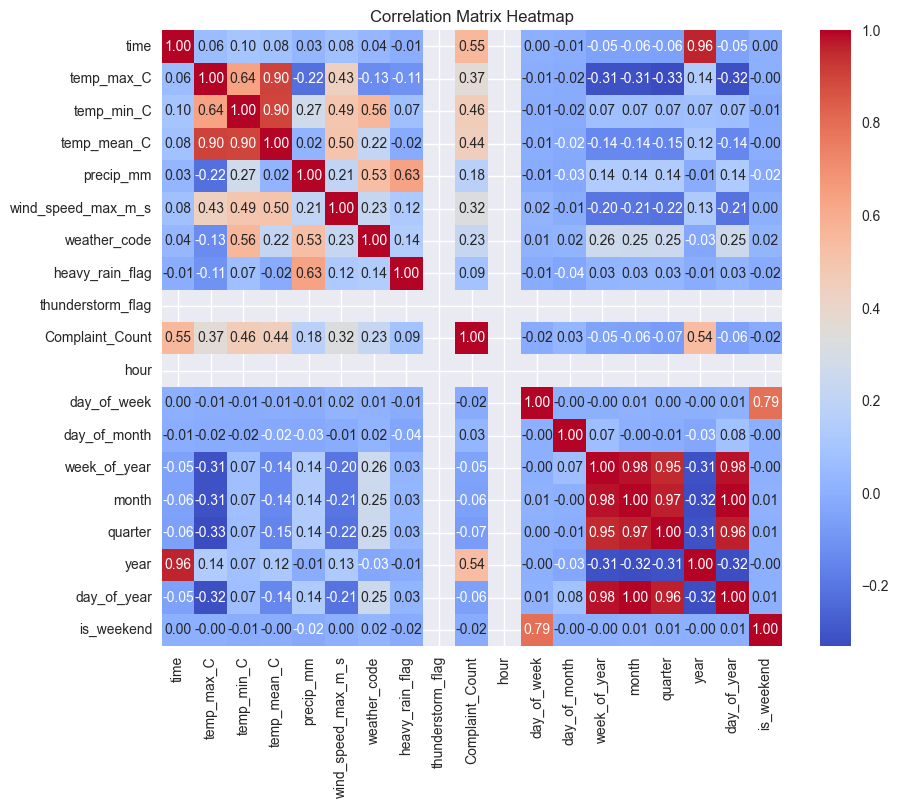

In [189]:
# 2. Pass the matrix to the seaborn heatmap function
plt.figure(figsize=(10, 8)) # Optional: set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [190]:
df.tail(2)

time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
1226 2025-10-18        30.5        20.6         25.5        0.0   
1227 2025-10-19        30.2        22.6         25.9        0.6   

      wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
1226                 6.3             0                0                  0   
1227                 9.4            51                0                  0   

      Complaint_Count  hour  day_of_week  day_of_month  week_of_year  month  \
1226               37     0            5            18            42     10   
1227               42     0            6            19            42     10   

      quarter  year  day_of_year  is_weekend  
1226        4  2025          291           1  
1227        4  2025          292           1

In [191]:
df.shape

(1228, 19)

In [192]:
import requests
import pandas as pd

# Define location and date range
latitude = 21.4669
longitude = 83.9812
start_date = "2022-06-10"
end_date = "2025-10-19"

# Open-Meteo API endpoint for daily humidity
url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily=relative_humidity_2m_mean&timezone=Asia%2FKolkata"
)

# Fetch and parse data
response = requests.get(url)
data = response.json()

# Check and convert to DataFrame
if 'daily' in data:
    df2 = pd.DataFrame(data['daily'])
    df2['time'] = pd.to_datetime(df2['time'])
    print(df2[['time', 'relative_humidity_2m_mean']])
else:
    print("No daily humidity data found. Check location, date, or API response.")



           time  relative_humidity_2m_mean
0    2022-06-10                         47
1    2022-06-11                         42
2    2022-06-12                         45
3    2022-06-13                         45
4    2022-06-14                         52
...         ...                        ...
1223 2025-10-15                         78
1224 2025-10-16                         75
1225 2025-10-17                         75
1226 2025-10-18                         77
1227 2025-10-19                         85

[1228 rows x 2 columns]


In [193]:
df2

time  relative_humidity_2m_mean
0    2022-06-10                         47
1    2022-06-11                         42
2    2022-06-12                         45
3    2022-06-13                         45
4    2022-06-14                         52
...         ...                        ...
1223 2025-10-15                         78
1224 2025-10-16                         75
1225 2025-10-17                         75
1226 2025-10-18                         77
1227 2025-10-19                         85

[1228 rows x 2 columns]

In [194]:
df.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
       'wind_speed_max_m_s', 'weather_code', 'heavy_rain_flag',
       'thunderstorm_flag', 'Complaint_Count', 'hour', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
       'day_of_year', 'is_weekend'],
      dtype='object')

In [195]:
df2.columns

Index(['time', 'relative_humidity_2m_mean'], dtype='object')

In [196]:
df_combined = pd.merge(df, df2, on='time', how='left')

In [197]:
df_combined

time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0    2022-06-10        41.0        30.3         34.6        0.1   
1    2022-06-11        41.0        30.8         34.8        0.2   
2    2022-06-12        39.8        29.5         34.4        0.0   
3    2022-06-13        40.2        29.5         34.7        0.0   
4    2022-06-14        39.2        30.0         32.9        8.6   
...         ...         ...         ...          ...        ...   
1223 2025-10-15        31.4        22.4         26.4        0.0   
1224 2025-10-16        30.9        22.2         25.9        0.0   
1225 2025-10-17        31.0        21.7         25.5        0.0   
1226 2025-10-18        30.5        20.6         25.5        0.0   
1227 2025-10-19        30.2        22.6         25.9        0.6   

      wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
0                   16.6            51                0                  0   
1                   25.3            51                0                  0   
2                   16.7             3                0                  0   
3                   13.3             3                0                  0   
4                   19.0            63                0                  0   
...                  ...           ...              ...                ...   
1223                 6.1             0                0                  0   
1224                 8.2             0                0                  0   
1225                 7.8             0                0                  0   
1226                 6.3             0                0                  0   
1227                 9.4            51                0                  0   

      Complaint_Count  hour  day_of_week  day_of_month  week_of_year  month  \
0                  10     0            4            10            23      6   
1                  12     0            5            11            23      6   
2                   5     0            6            12            23      6   
3                  15     0            0            13            24      6   
4                  16     0            1            14            24      6   
...               ...   ...          ...           ...           ...    ...   
1223               18     0            2            15            42     10   
1224               18     0            3            16            42     10   
1225               17     0            4            17            42     10   
1226               37     0            5            18            42     10   
1227               42     0            6            19            42     10   

      quarter  year  day_of_year  is_weekend  relative_humidity_2m_mean  
0           2  2022          161           0                         47  
1           2  2022          162           1                         42  
2           2  2022          163           1                         45  
3           2  2022          164           0                         45  
4           2  2022          165           0                         52  
...       ...   ...          ...         ...                        ...  
1223        4  2025          288           0                         78  
1224        4  2025          289           0                         75  
1225        4  2025          290           0                         75  
1226        4  2025          291           1                         77  
1227        4  2025          292           1                         85  

[1228 rows x 20 columns]

In [198]:
df_combined.isnull().sum()

time                         0
temp_max_C                   0
temp_min_C                   0
temp_mean_C                  0
precip_mm                    0
wind_speed_max_m_s           0
weather_code                 0
heavy_rain_flag              0
thunderstorm_flag            0
Complaint_Count              0
hour                         0
day_of_week                  0
day_of_month                 0
week_of_year                 0
month                        0
quarter                      0
year                         0
day_of_year                  0
is_weekend                   0
relative_humidity_2m_mean    0
dtype: int64

In [199]:
df_combined.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
       'wind_speed_max_m_s', 'weather_code', 'heavy_rain_flag',
       'thunderstorm_flag', 'Complaint_Count', 'hour', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
       'day_of_year', 'is_weekend', 'relative_humidity_2m_mean'],
      dtype='object')

In [200]:
# ================================================================
# 2️⃣ RULE-BASED CLASSIFICATION (IMD + Odisha logic)
# ================================================================
def classify_weather(row):
    precip = row.get('precip_mm', 0)
    wind = row.get('wind_speed_max_m_s', 0)
    hum = row.get('relative_humidity_2m_mean', 0)
    weather = str(row.get('weather_code', '')).lower()

    if (precip == 0 and 'rain' not in weather and 'thunder' not in weather):
        return "No Rain"
    elif (0 < precip <= 2.5) or ('light rain' in weather) or (hum > 80 and precip < 3):
        return "Light Rain"
    elif (2.5 < precip <= 7.5) or ('moderate' in weather):
        return "Moderate Rain"
    elif (7.5 < precip <= 35) or ('heavy rain' in weather):
        return "Heavy Rain"
    elif (precip > 35) or (wind > 7.0) or ('thunder' in weather) or ('storm' in weather):
        return "Thunderstorm"
    else:
        return "No Rain"

# Apply safely
df_combined['weather_label'] = df_combined.apply(classify_weather, axis=1)


In [201]:
df_combined

time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0    2022-06-10        41.0        30.3         34.6        0.1   
1    2022-06-11        41.0        30.8         34.8        0.2   
2    2022-06-12        39.8        29.5         34.4        0.0   
3    2022-06-13        40.2        29.5         34.7        0.0   
4    2022-06-14        39.2        30.0         32.9        8.6   
...         ...         ...         ...          ...        ...   
1223 2025-10-15        31.4        22.4         26.4        0.0   
1224 2025-10-16        30.9        22.2         25.9        0.0   
1225 2025-10-17        31.0        21.7         25.5        0.0   
1226 2025-10-18        30.5        20.6         25.5        0.0   
1227 2025-10-19        30.2        22.6         25.9        0.6   

      wind_speed_max_m_s  weather_code  heavy_rain_flag  thunderstorm_flag  \
0                   16.6            51                0                  0   
1                   25.3            51                0                  0   
2                   16.7             3                0                  0   
3                   13.3             3                0                  0   
4                   19.0            63                0                  0   
...                  ...           ...              ...                ...   
1223                 6.1             0                0                  0   
1224                 8.2             0                0                  0   
1225                 7.8             0                0                  0   
1226                 6.3             0                0                  0   
1227                 9.4            51                0                  0   

      Complaint_Count  ...  day_of_week  day_of_month  week_of_year  month  \
0                  10  ...            4            10            23      6   
1                  12  ...            5            11            23      6   
2                   5  ...            6            12            23      6   
3                  15  ...            0            13            24      6   
4                  16  ...            1            14            24      6   
...               ...  ...          ...           ...           ...    ...   
1223               18  ...            2            15            42     10   
1224               18  ...            3            16            42     10   
1225               17  ...            4            17            42     10   
1226               37  ...            5            18            42     10   
1227               42  ...            6            19            42     10   

      quarter  year  day_of_year  is_weekend  relative_humidity_2m_mean  \
0           2  2022          161           0                         47   
1           2  2022          162           1                         42   
2           2  2022          163           1                         45   
3           2  2022          164           0                         45   
4           2  2022          165           0                         52   
...       ...   ...          ...         ...                        ...   
1223        4  2025          288           0                         78   
1224        4  2025          289           0                         75   
1225        4  2025          290           0                         75   
1226        4  2025          291           1                         77   
1227        4  2025          292           1                         85   

      weather_label  
0        Light Rain  
1        Light Rain  
2           No Rain  
3           No Rain  
4        Heavy Rain  
...             ...  
1223        No Rain  
1224        No Rain  
1225        No Rain  
1226        No Rain  
1227     Light Rain  

[1228 rows x 21 columns]

In [202]:
df_combined['weather_label'].value_counts()

weather_label
No Rain          612
Heavy Rain       231
Light Rain       228
Moderate Rain    116
Thunderstorm      41
Name: count, dtype: int64

In [203]:
df_combined.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
       'wind_speed_max_m_s', 'weather_code', 'heavy_rain_flag',
       'thunderstorm_flag', 'Complaint_Count', 'hour', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
       'day_of_year', 'is_weekend', 'relative_humidity_2m_mean',
       'weather_label'],
      dtype='object')

In [204]:
final_df = df_combined[[
    'time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
    'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'day_of_week',
    'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
    'day_of_year', 'is_weekend', 'relative_humidity_2m_mean',
    'weather_label'
]]

In [205]:
final_df.head()

time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0 2022-06-10        41.0        30.3         34.6        0.1   
1 2022-06-11        41.0        30.8         34.8        0.2   
2 2022-06-12        39.8        29.5         34.4        0.0   
3 2022-06-13        40.2        29.5         34.7        0.0   
4 2022-06-14        39.2        30.0         32.9        8.6   

   wind_speed_max_m_s  weather_code  Complaint_Count  day_of_week  \
0                16.6            51               10            4   
1                25.3            51               12            5   
2                16.7             3                5            6   
3                13.3             3               15            0   
4                19.0            63               16            1   

   day_of_month  week_of_year  month  quarter  year  day_of_year  is_weekend  \
0            10            23      6        2  2022          161           0   
1            11            23      6        2  2022          162           1   
2            12            23      6        2  2022          163           1   
3            13            24      6        2  2022          164           0   
4            14            24      6        2  2022          165           0   

   relative_humidity_2m_mean weather_label  
0                         47    Light Rain  
1                         42    Light Rain  
2                         45       No Rain  
3                         45       No Rain  
4                         52    Heavy Rain

In [206]:
final_df.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
       'day_of_year', 'is_weekend', 'relative_humidity_2m_mean',
       'weather_label'],
      dtype='object')

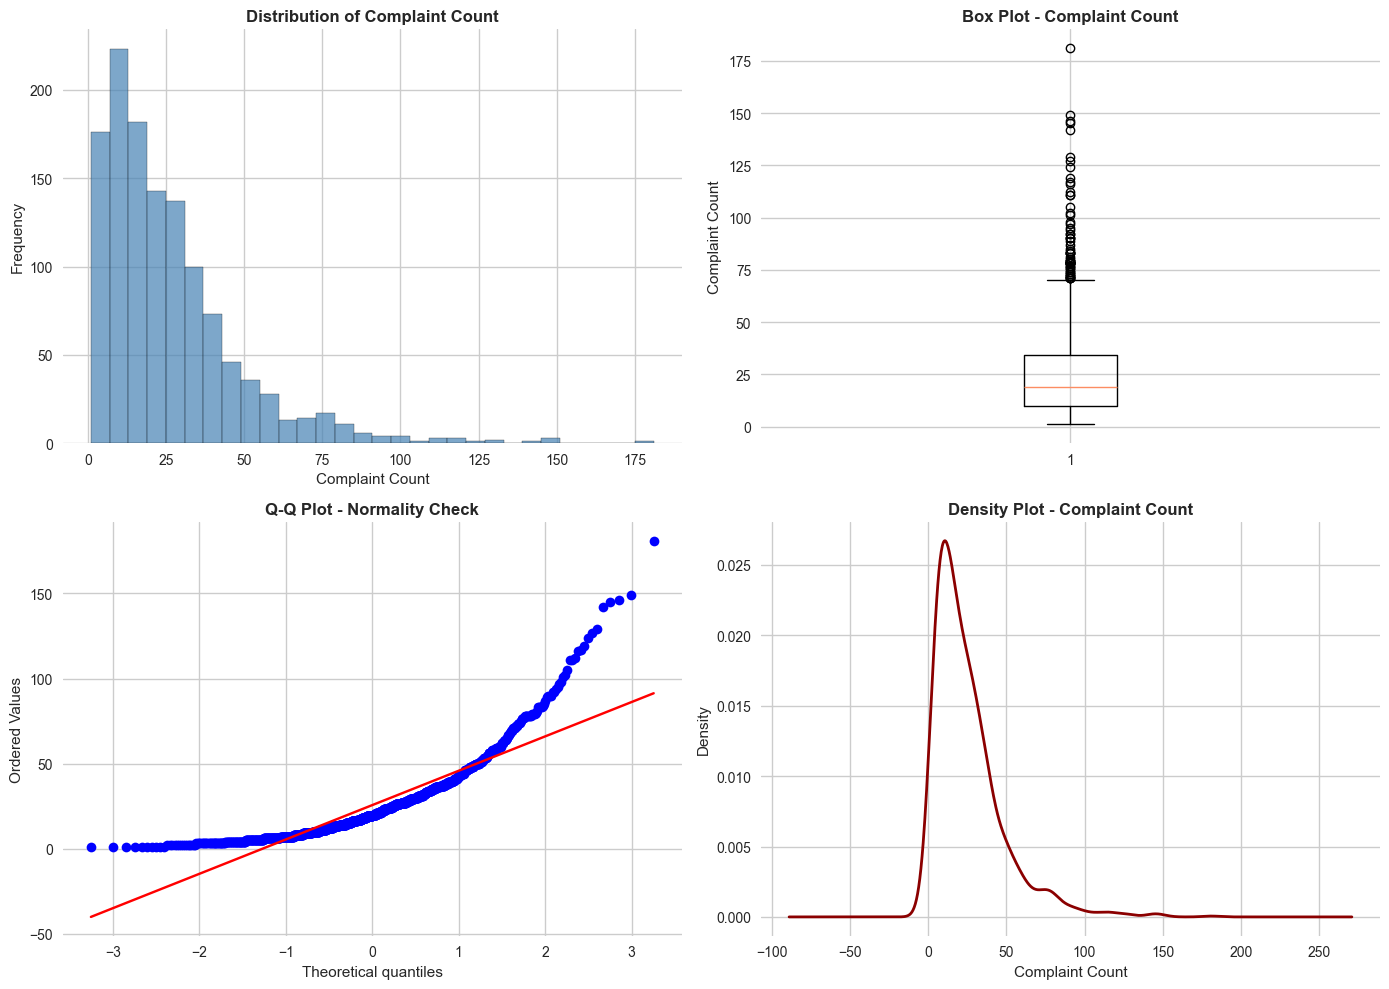

In [207]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# --- 1. Distribution of Complaint Count ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram with KDE
axes[0, 0].hist(final_df['Complaint_Count'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Distribution of Complaint Count', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Complaint Count')
axes[0, 0].set_ylabel('Frequency')

# Box plot
axes[0, 1].boxplot(final_df['Complaint_Count'], vert=True)
axes[0, 1].set_title('Box Plot - Complaint Count', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Complaint Count')
# Q-Q Plot
from scipy import stats
stats.probplot(final_df['Complaint_Count'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot - Normality Check', fontsize=12, fontweight='bold')

# Density Plot
final_df['Complaint_Count'].plot(kind='density', ax=axes[1, 1], color='darkred', linewidth=2)
axes[1, 1].set_title('Density Plot - Complaint Count', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Complaint Count')

plt.tight_layout()
plt.show()

In [208]:
# Summary Statistics
print("=" * 60)
print("UNIVARIATE STATISTICS - Complaint Count")
print("=" * 60)
print(final_df['Complaint_Count'].describe())
print(f"Skewness: {final_df['Complaint_Count'].skew():.3f}")
print(f"Kurtosis: {final_df['Complaint_Count'].kurtosis():.3f}")
print()

UNIVARIATE STATISTICS - Complaint Count
count    1228.000000
mean       25.571661
std        22.271619
min         1.000000
25%        10.000000
50%        19.000000
75%        34.000000
max       181.000000
Name: Complaint_Count, dtype: float64
Skewness: 2.080
Kurtosis: 6.500



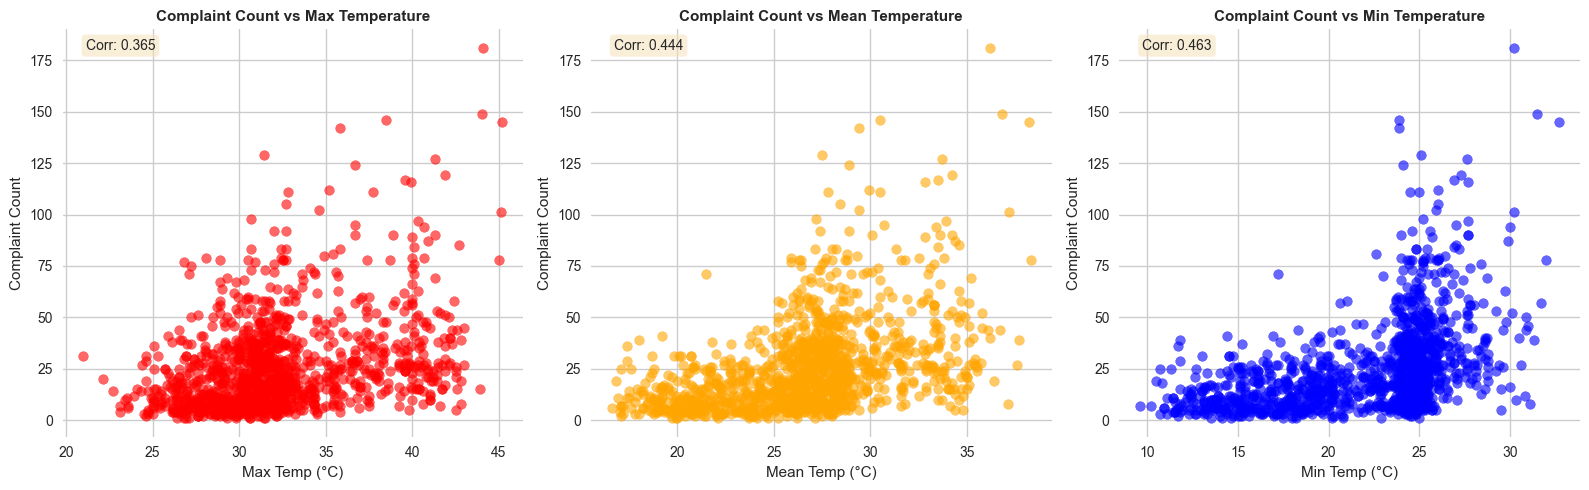

In [209]:
# ============================================================================
# BIVARIATE ANALYSIS - Complaint Count vs Each Feature
# ============================================================================

# --- 2. Complaint Count vs Temperature Features ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].scatter(final_df['temp_max_C'], final_df['Complaint_Count'], alpha=0.6, color='red')
axes[0].set_title('Complaint Count vs Max Temperature', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Max Temp (°C)')
axes[0].set_ylabel('Complaint Count')
corr_temp_max = final_df['temp_max_C'].corr(final_df['Complaint_Count'])
axes[0].text(0.05, 0.95, f'Corr: {corr_temp_max:.3f}', transform=axes[0].transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].scatter(final_df['temp_mean_C'], final_df['Complaint_Count'], alpha=0.6, color='orange')
axes[1].set_title('Complaint Count vs Mean Temperature', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Mean Temp (°C)')
axes[1].set_ylabel('Complaint Count')
corr_temp_mean = final_df['temp_mean_C'].corr(final_df['Complaint_Count'])
axes[1].text(0.05, 0.95, f'Corr: {corr_temp_mean:.3f}', transform=axes[1].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[2].scatter(final_df['temp_min_C'], final_df['Complaint_Count'], alpha=0.6, color='blue')
axes[2].set_title('Complaint Count vs Min Temperature', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Min Temp (°C)')
axes[2].set_ylabel('Complaint Count')
corr_temp_min = final_df['temp_min_C'].corr(final_df['Complaint_Count'])
axes[2].text(0.05, 0.95, f'Corr: {corr_temp_min:.3f}', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

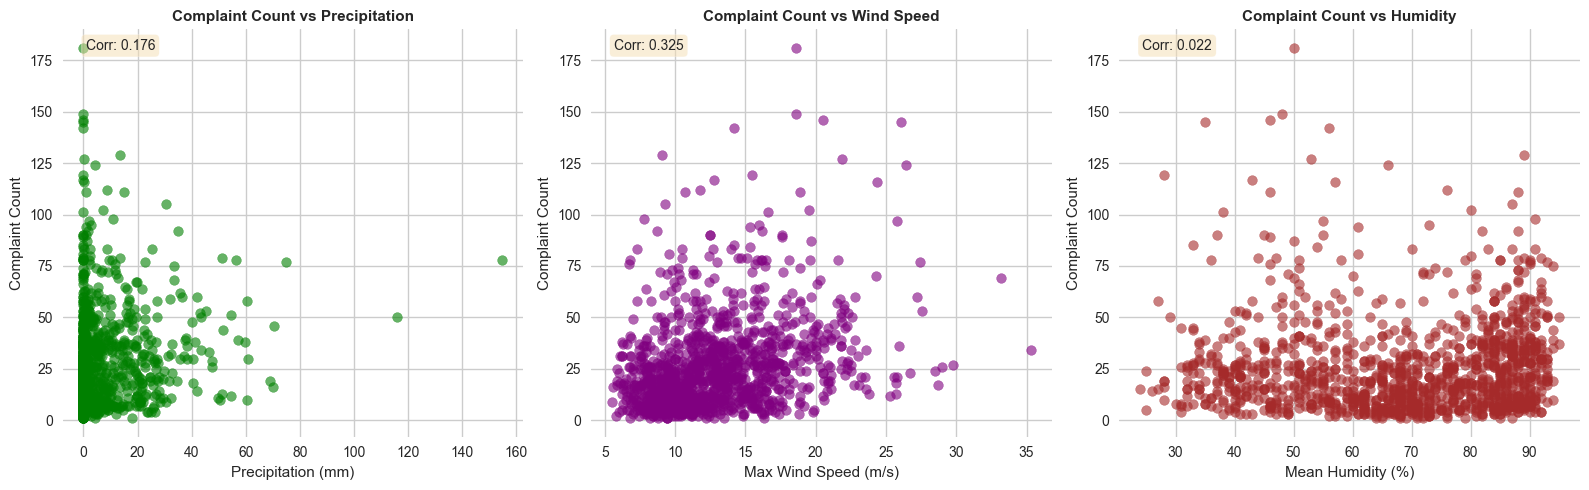

In [210]:
# --- 3. Complaint Count vs Weather Features ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].scatter(final_df['precip_mm'], final_df['Complaint_Count'], alpha=0.6, color='green')
axes[0].set_title('Complaint Count vs Precipitation', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Precipitation (mm)')
axes[0].set_ylabel('Complaint Count')
corr_precip = final_df['precip_mm'].corr(final_df['Complaint_Count'])
axes[0].text(0.05, 0.95, f'Corr: {corr_precip:.3f}', transform=axes[0].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].scatter(final_df['wind_speed_max_m_s'], final_df['Complaint_Count'], alpha=0.6, color='purple')
axes[1].set_title('Complaint Count vs Wind Speed', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Max Wind Speed (m/s)')
axes[1].set_ylabel('Complaint Count')
corr_wind = final_df['wind_speed_max_m_s'].corr(final_df['Complaint_Count'])
axes[1].text(0.05, 0.95, f'Corr: {corr_wind:.3f}', transform=axes[1].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[2].scatter(final_df['relative_humidity_2m_mean'], final_df['Complaint_Count'], alpha=0.6, color='brown')
axes[2].set_title('Complaint Count vs Humidity', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Mean Humidity (%)')
axes[2].set_ylabel('Complaint Count')
corr_humidity = final_df['relative_humidity_2m_mean'].corr(final_df['Complaint_Count'])
axes[2].text(0.05, 0.95, f'Corr: {corr_humidity:.3f}', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

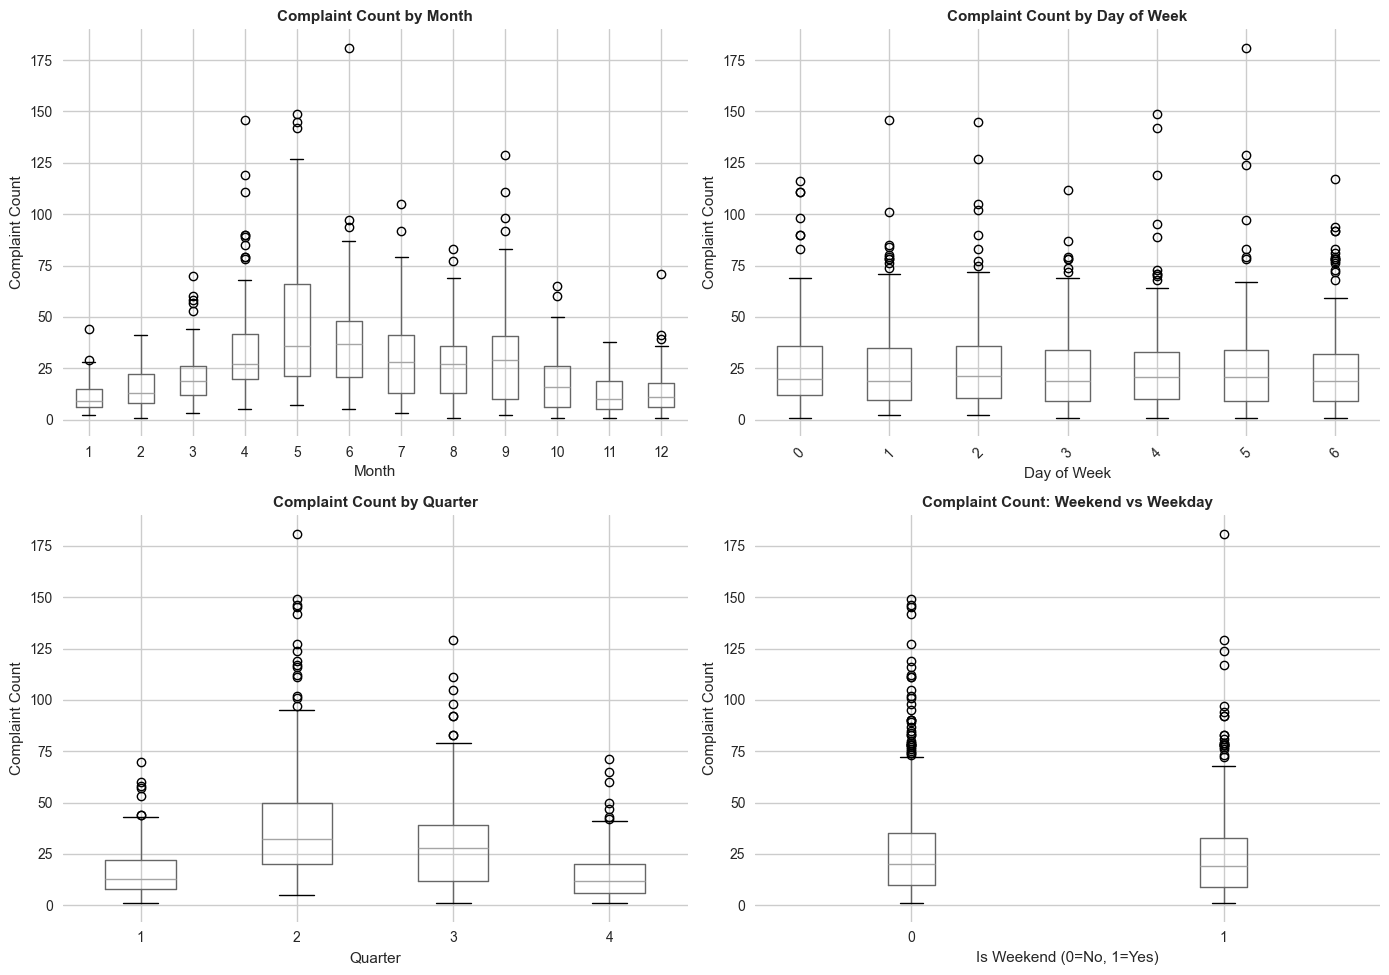

In [211]:
# --- 4. Complaint Count vs Temporal Features ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

final_df.boxplot(column='Complaint_Count', by='month', ax=axes[0, 0])
axes[0, 0].set_title('Complaint Count by Month', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Complaint Count')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

final_df.boxplot(column='Complaint_Count', by='day_of_week', ax=axes[0, 1])
axes[0, 1].set_title('Complaint Count by Day of Week', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Complaint Count')
plt.sca(axes[0, 1])
plt.xticks(rotation=45)

final_df.boxplot(column='Complaint_Count', by='quarter', ax=axes[1, 0])
axes[1, 0].set_title('Complaint Count by Quarter', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Quarter')
axes[1, 0].set_ylabel('Complaint Count')

final_df.boxplot(column='Complaint_Count', by='is_weekend', ax=axes[1, 1])
axes[1, 1].set_title('Complaint Count: Weekend vs Weekday', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Is Weekend (0=No, 1=Yes)')
axes[1, 1].set_ylabel('Complaint Count')

plt.suptitle('')
plt.tight_layout()

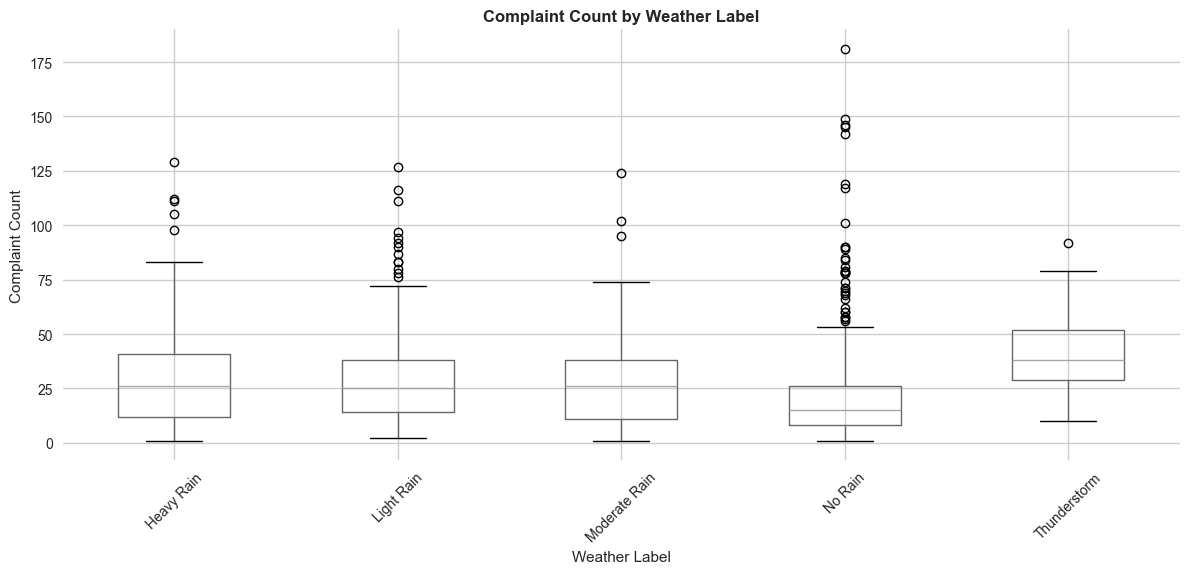


BIVARIATE CORRELATIONS WITH COMPLAINT COUNT
temp_max_C..............................   0.3653
temp_min_C..............................   0.4626
temp_mean_C.............................   0.4438
precip_mm...............................   0.1763
wind_speed_max_m_s......................   0.3249
weather_code............................   0.2299
day_of_week.............................  -0.0186
day_of_month............................   0.0282
week_of_year............................  -0.0477
month...................................  -0.0574
quarter.................................  -0.0726
year....................................   0.5399
day_of_year.............................  -0.0559
is_weekend..............................  -0.0160
relative_humidity_2m_mean...............   0.0223



In [212]:
# --- 5. Complaint Count vs Weather Label ---
fig, ax = plt.subplots(figsize=(12, 6))
final_df.boxplot(column='Complaint_Count', by='weather_label', ax=ax)
ax.set_title('Complaint Count by Weather Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Weather Label')
ax.set_ylabel('Complaint Count')
plt.suptitle('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("BIVARIATE CORRELATIONS WITH COMPLAINT COUNT")
print("=" * 60)
numeric_cols = final_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'Complaint_Count':
        corr = final_df[col].corr(final_df['Complaint_Count'])
        print(f"{col:.<40} {corr:>8.4f}")
print()

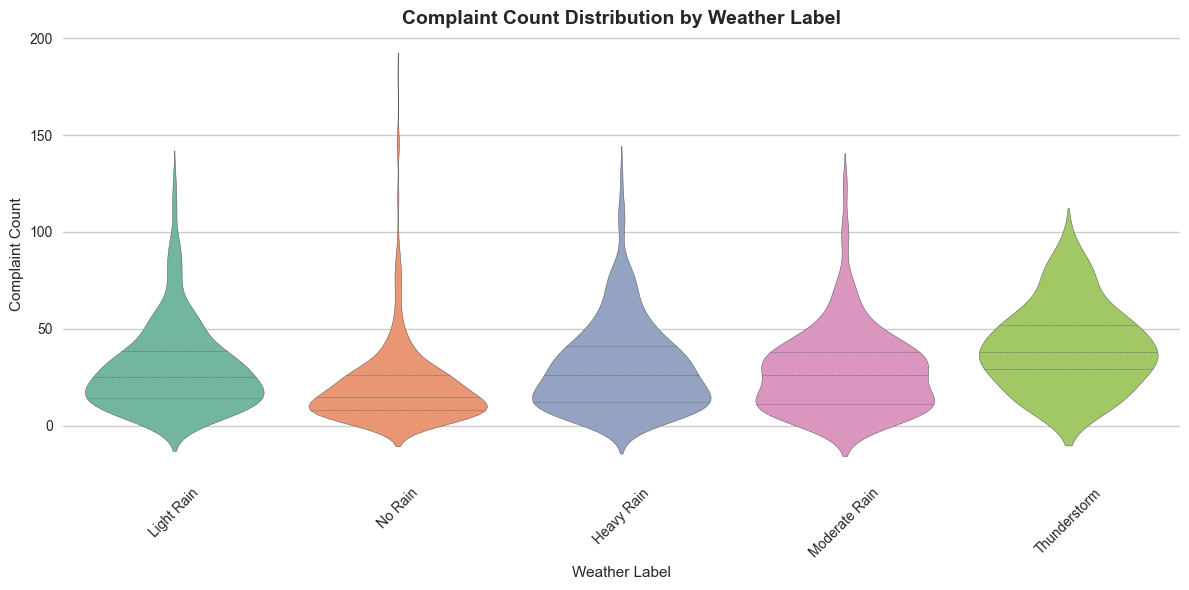

In [213]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=final_df, x='weather_label', y='Complaint_Count', palette='Set2', inner='quartile')
plt.title('Complaint Count Distribution by Weather Label', fontsize=14, fontweight='bold')
plt.xlabel('Weather Label')
plt.ylabel('Complaint Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

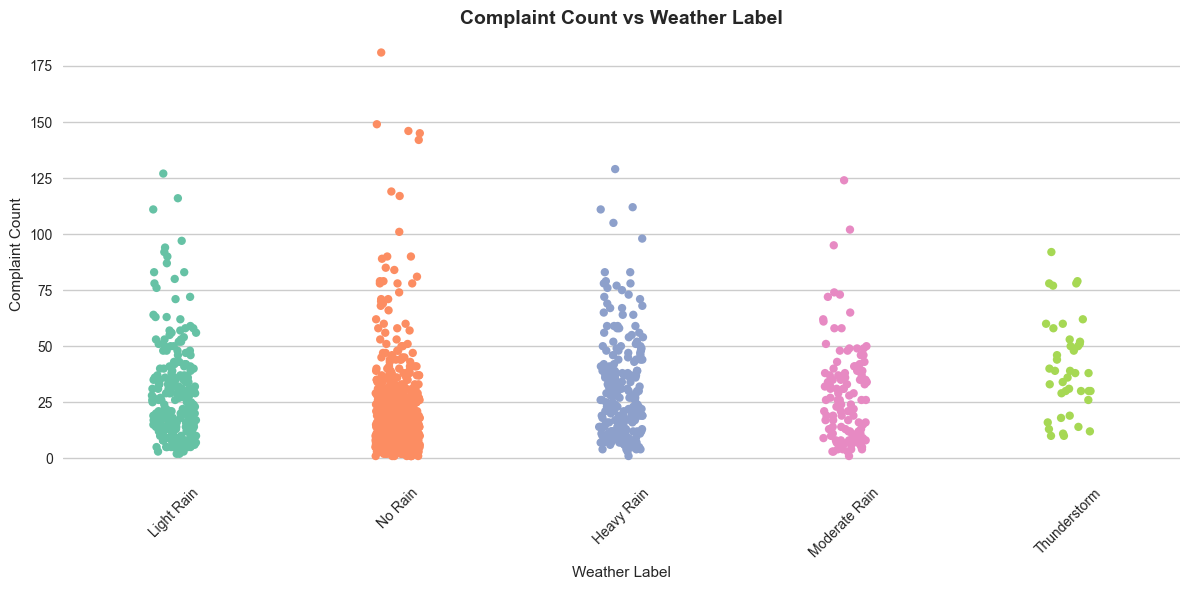

In [214]:
plt.figure(figsize=(12, 6))
sns.stripplot(data=final_df, x='weather_label', y='Complaint_Count', jitter=True, palette='Set2', size=6)
plt.title('Complaint Count vs Weather Label', fontsize=14, fontweight='bold')
plt.xlabel('Weather Label')
plt.ylabel('Complaint Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

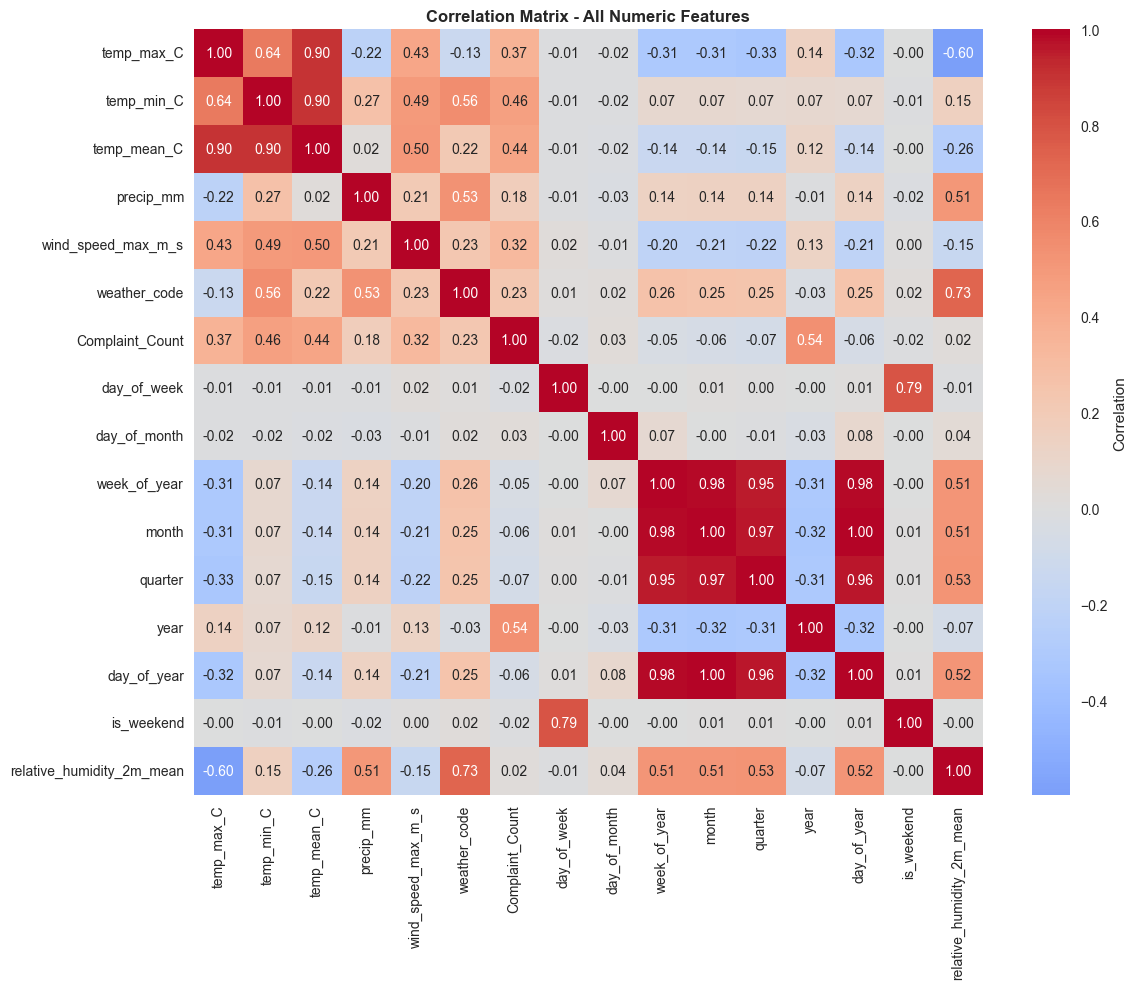

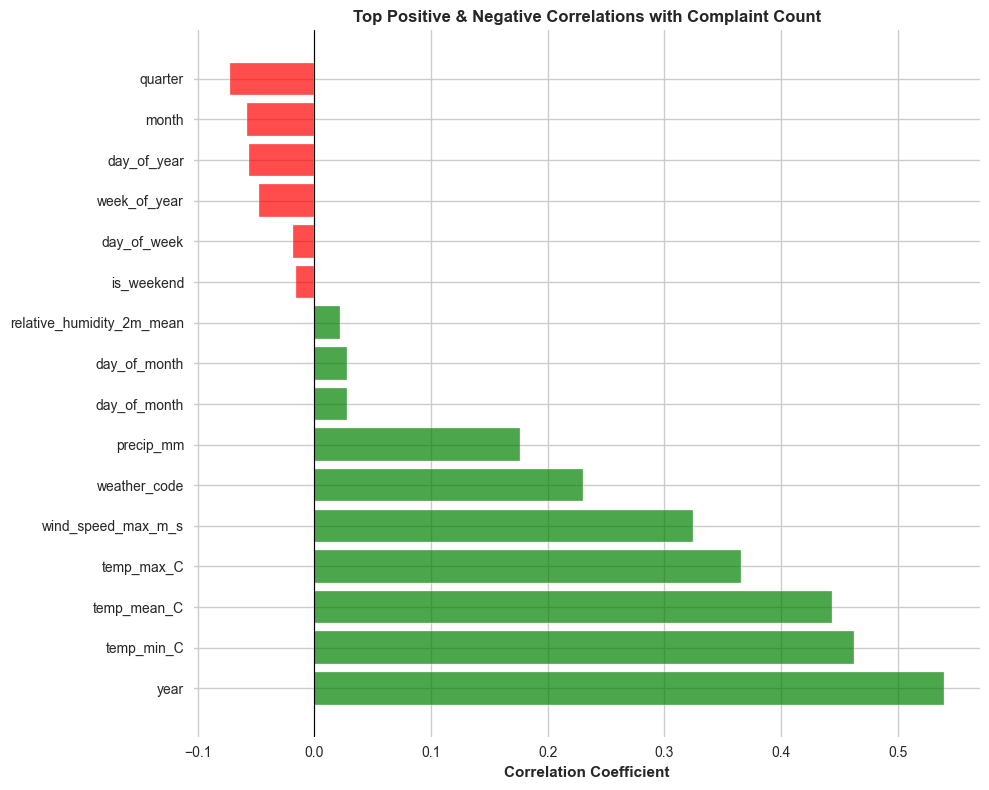

In [215]:
# ============================================================================
# MULTIVARIATE ANALYSIS - Multiple Features vs Complaint Count
# ============================================================================

# --- 6. Correlation Heatmap ---
fig, ax = plt.subplots(figsize=(12, 10))
numeric_df = final_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix - All Numeric Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 7. Top Correlations with Complaint Count ---
fig, ax = plt.subplots(figsize=(10, 8))
correlations = numeric_df.corr()['Complaint_Count'].drop('Complaint_Count').sort_values(ascending=False)
top_corr = pd.concat([correlations.head(8), correlations.tail(8)])
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
ax.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr.index)
ax.set_xlabel('Correlation Coefficient', fontweight='bold')
ax.set_title('Top Positive & Negative Correlations with Complaint Count', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

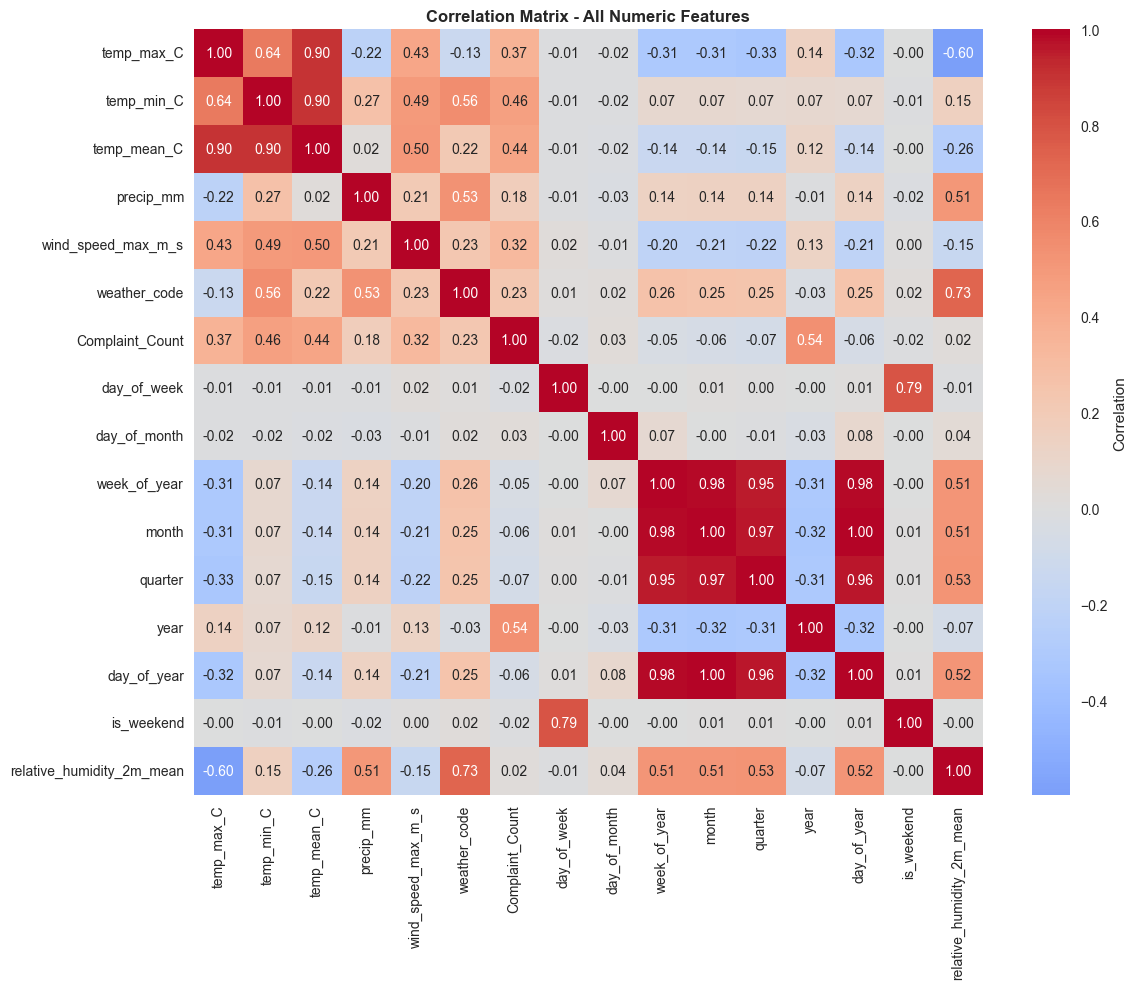

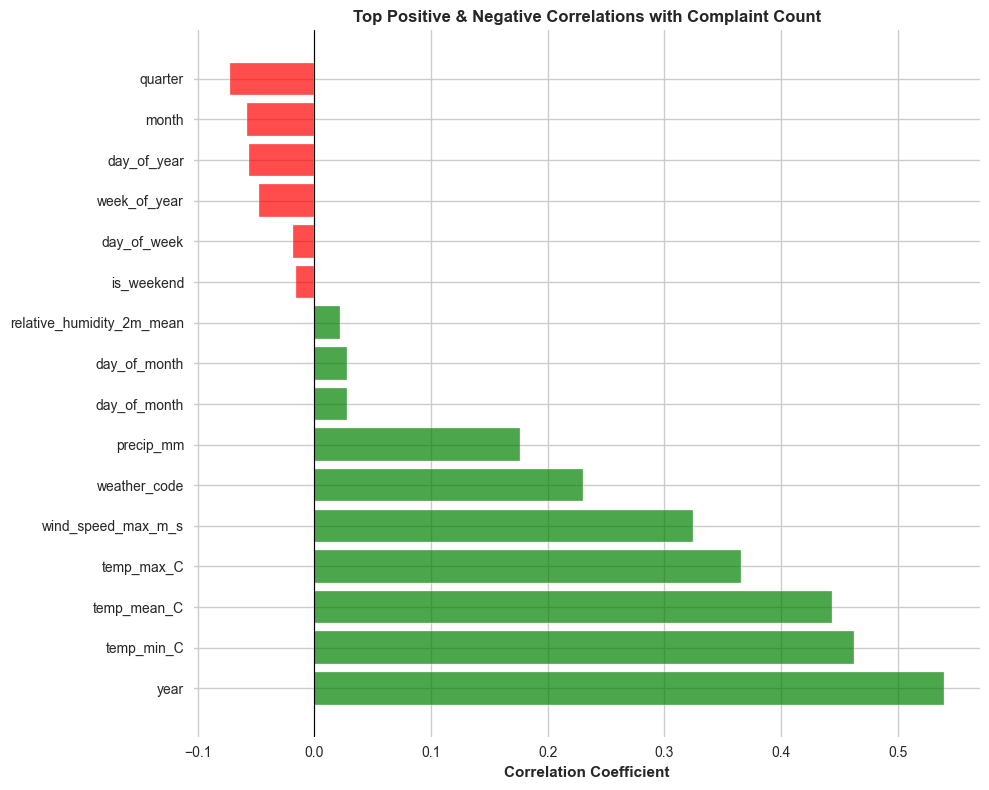

<Figure size 1400x1000 with 0 Axes>

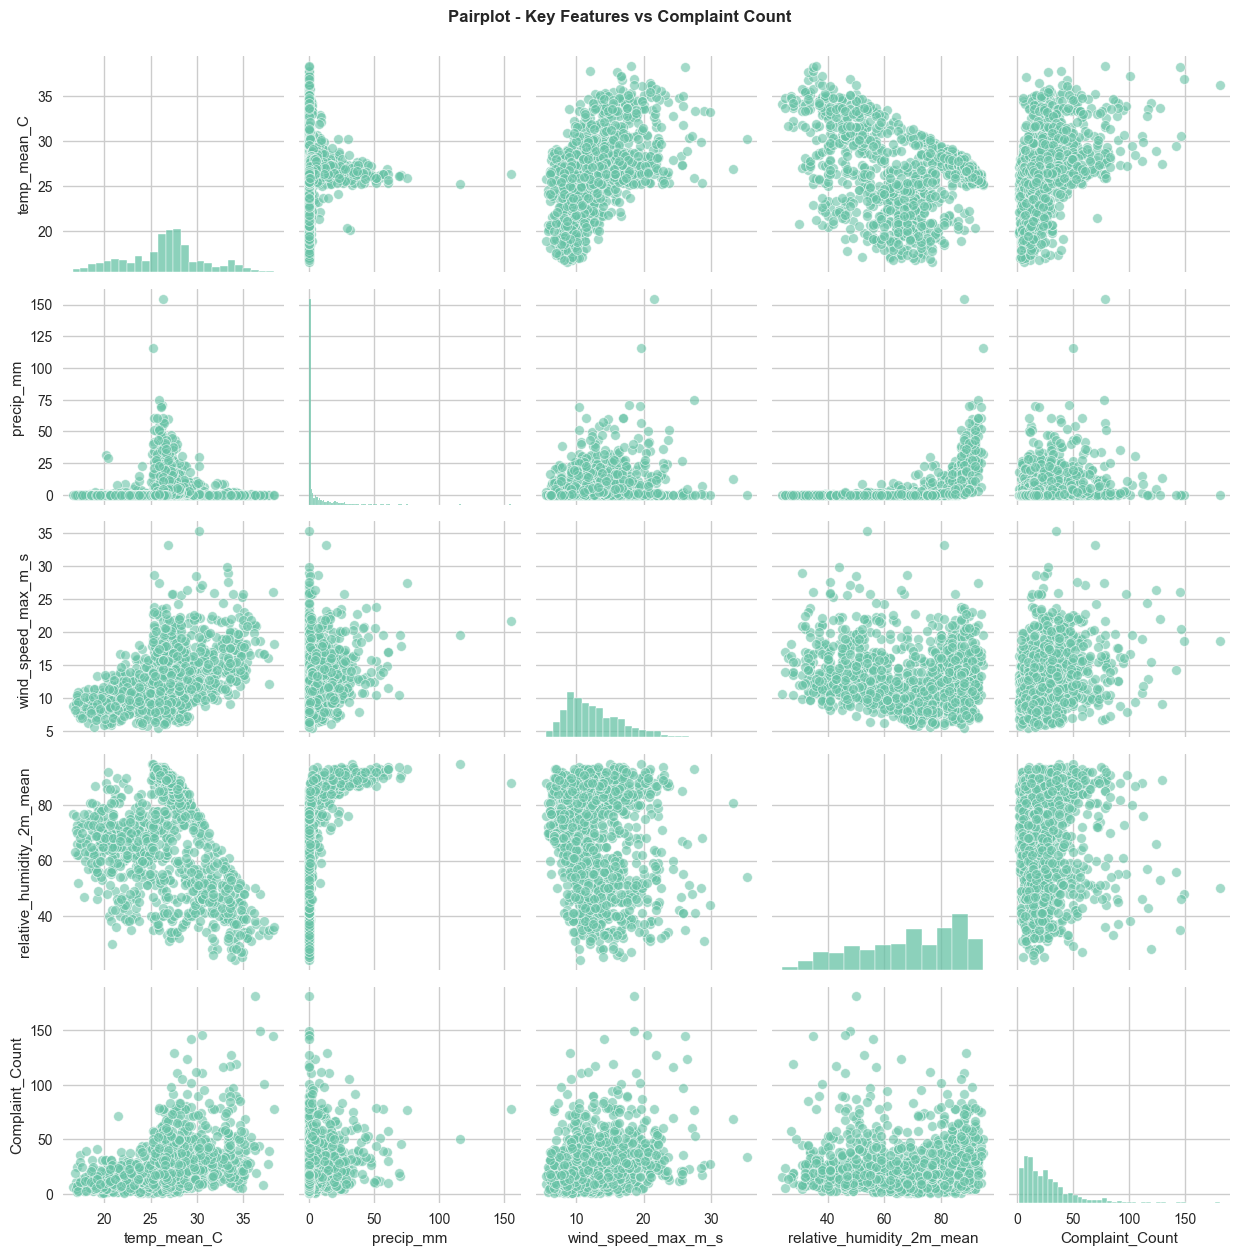

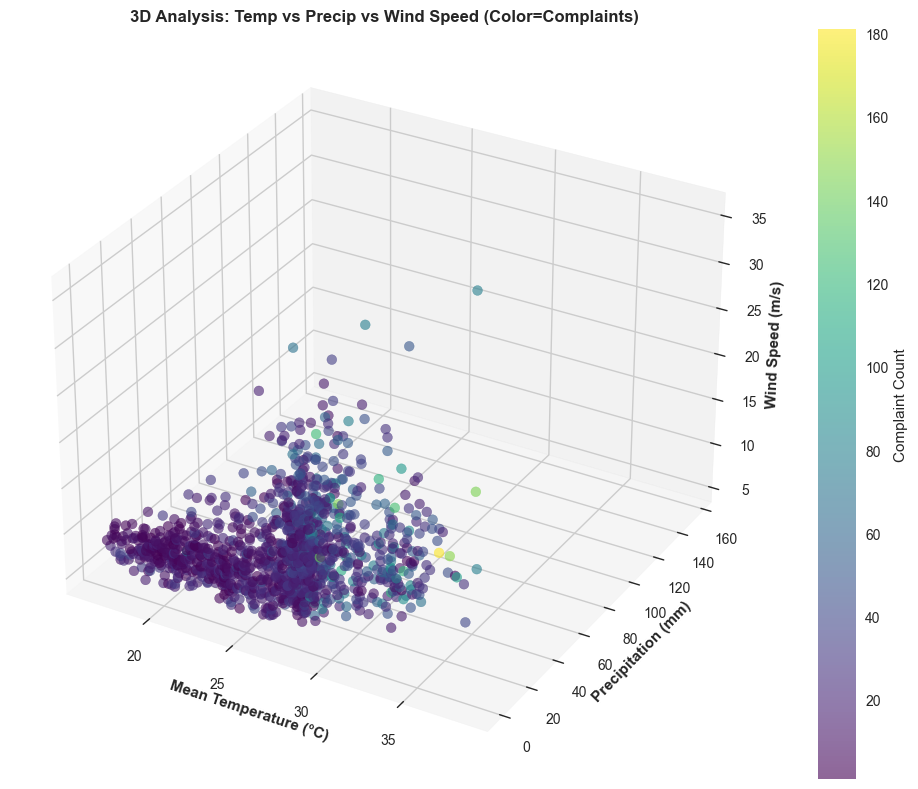

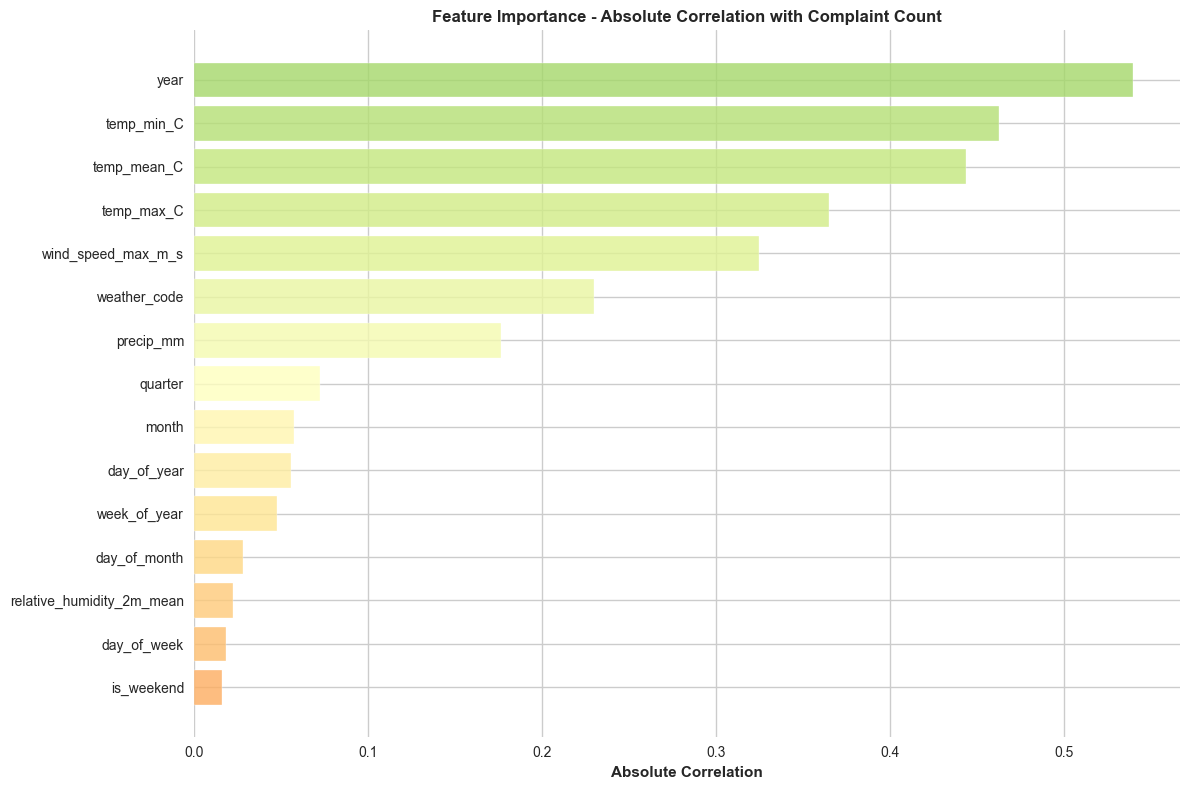

In [216]:
# ============================================================================
# MULTIVARIATE ANALYSIS - Multiple Features vs Complaint Count
# ============================================================================

# --- 6. Correlation Heatmap ---
fig, ax = plt.subplots(figsize=(12, 10))
numeric_df = final_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix - All Numeric Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 7. Top Correlations with Complaint Count ---
fig, ax = plt.subplots(figsize=(10, 8))
correlations = numeric_df.corr()['Complaint_Count'].drop('Complaint_Count').sort_values(ascending=False)
top_corr = pd.concat([correlations.head(8), correlations.tail(8)])
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
ax.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr.index)
ax.set_xlabel('Correlation Coefficient', fontweight='bold')
ax.set_title('Top Positive & Negative Correlations with Complaint Count', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

# --- 8. Pairplot - Key Features ---
fig = plt.figure(figsize=(14, 10))
key_features = ['temp_mean_C', 'precip_mm', 'wind_speed_max_m_s', 
                'relative_humidity_2m_mean', 'Complaint_Count']
sns.pairplot(final_df[key_features], diag_kind='hist', plot_kws={'alpha':0.6})
plt.suptitle('Pairplot - Key Features vs Complaint Count', fontsize=12, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# --- 9. 3D Scatter Plot ---
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(final_df['temp_mean_C'], final_df['precip_mm'], 
                     final_df['wind_speed_max_m_s'], 
                     c=final_df['Complaint_Count'], cmap='viridis', s=50, alpha=0.6)
ax.set_xlabel('Mean Temperature (°C)', fontweight='bold')
ax.set_ylabel('Precipitation (mm)', fontweight='bold')
ax.set_zlabel('Wind Speed (m/s)', fontweight='bold')
ax.set_title('3D Analysis: Temp vs Precip vs Wind Speed (Color=Complaints)', fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Complaint Count')
plt.tight_layout()
plt.show()

# --- 10. Feature Importance via Correlation Strength ---
fig, ax = plt.subplots(figsize=(12, 8))
abs_corr = numeric_df.corr()['Complaint_Count'].drop('Complaint_Count').abs().sort_values(ascending=True)
colors_importance = plt.cm.RdYlGn(np.linspace(0.3, 0.7, len(abs_corr)))
ax.barh(range(len(abs_corr)), abs_corr.values, color=colors_importance, alpha=0.8)
ax.set_yticks(range(len(abs_corr)))
ax.set_yticklabels(abs_corr.index)
ax.set_xlabel('Absolute Correlation', fontweight='bold')
ax.set_title('Feature Importance - Absolute Correlation with Complaint Count', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



In [217]:
final_df.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
       'day_of_year', 'is_weekend', 'relative_humidity_2m_mean',
       'weather_label'],
      dtype='object')

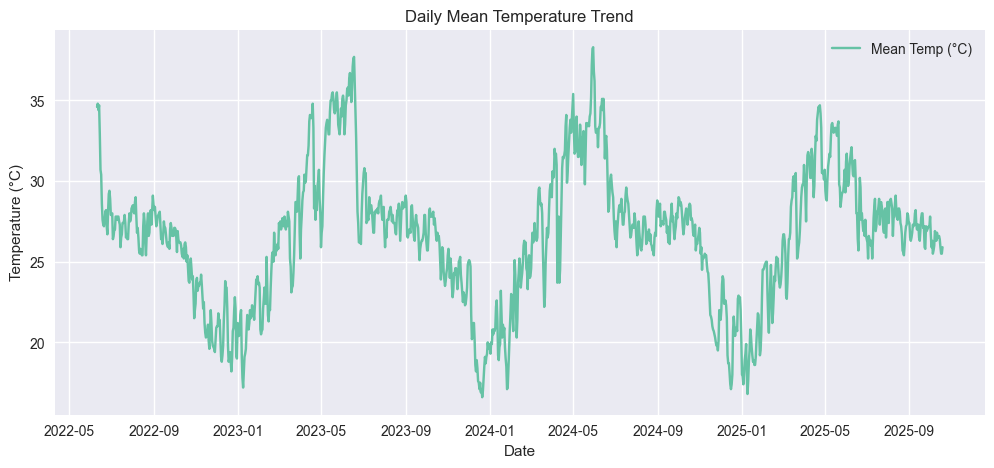

In [218]:
# Optional: for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')
# Line Chart: Daily temperature trend
plt.figure(figsize=(12, 5))
plt.plot(final_df['time'], final_df['temp_mean_C'], label='Mean Temp (°C)')
plt.title('Daily Mean Temperature Trend')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


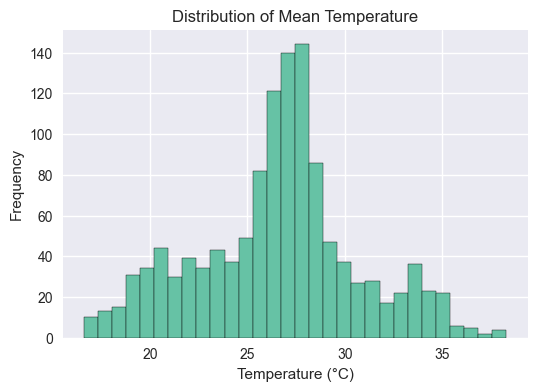

In [219]:
# Histogram: Distribution of mean temperature
plt.figure(figsize=(6, 4))
plt.hist(final_df['temp_mean_C'], bins=30, edgecolor='black')
plt.title('Distribution of Mean Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

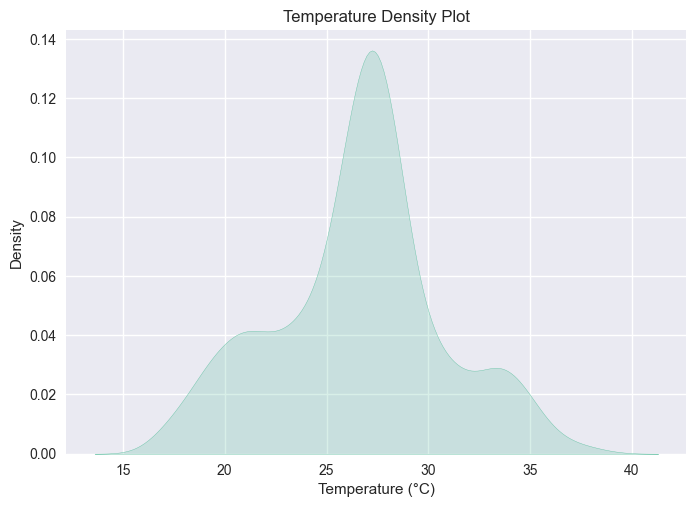

In [220]:
# Density Plot (KDE)
sns.kdeplot(final_df['temp_mean_C'], fill=True)
plt.title('Temperature Density Plot')
plt.xlabel('Temperature (°C)')
plt.show()

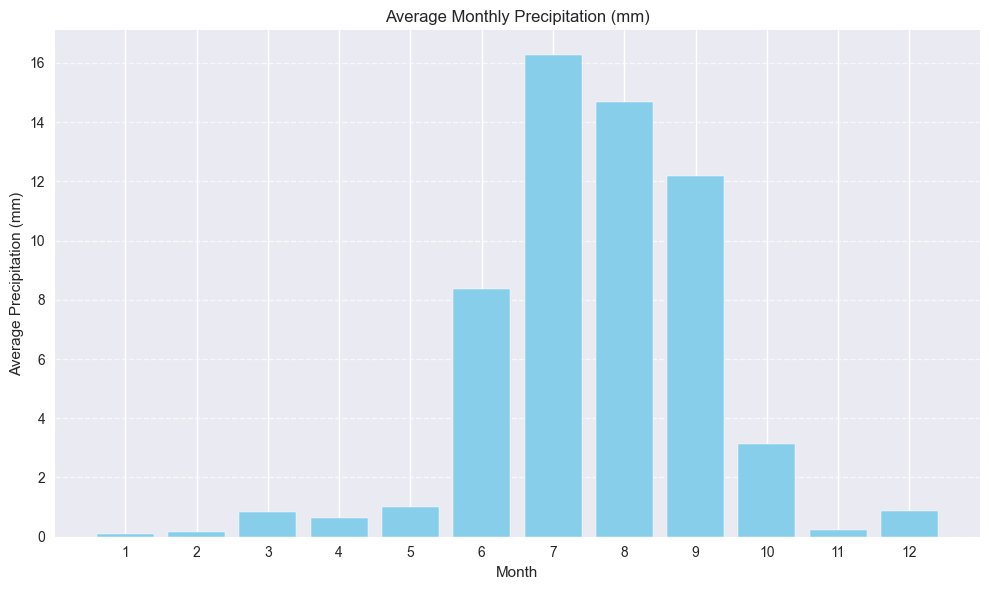

In [221]:
# 1. Calculate the mean precipitation for each month
monthly_precip_mean = final_df.groupby('month')['precip_mm'].mean()

# 2. Use the result's index (months) for the x-axis and values (mean precip) for the height
plt.figure(figsize=(10, 6))
plt.bar(
    monthly_precip_mean.index.astype(str),  # x-axis: Month numbers as strings for clean labels
    monthly_precip_mean.values,             # height: The calculated mean precipitation
    color='skyblue'
)

# 3. Add titles and labels for clarity
plt.title('Average Monthly Precipitation (mm)')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.xticks(rotation=0) # Keep x-labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


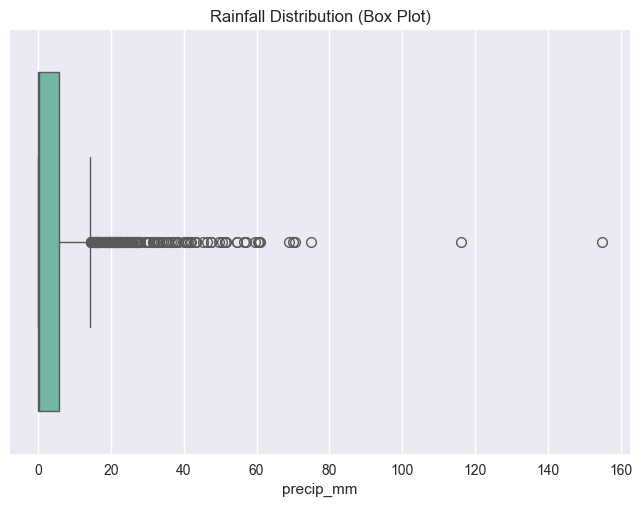

In [222]:
# Box Plot
sns.boxplot(x=final_df['precip_mm'])
plt.title('Rainfall Distribution (Box Plot)')
plt.show()


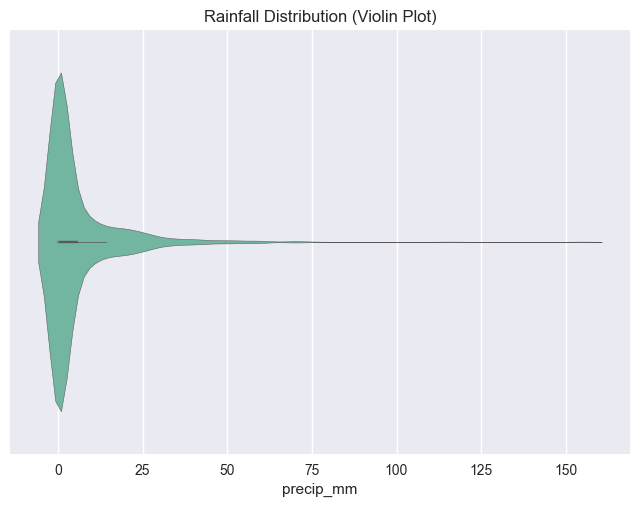

In [223]:
# Violin Plot
sns.violinplot(x=final_df['precip_mm'])
plt.title('Rainfall Distribution (Violin Plot)')
plt.show()

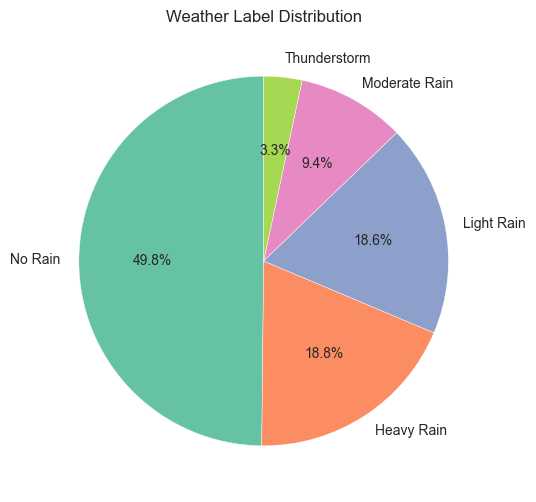

In [224]:
# Pie Chart: Weather Label Distribution
weather_counts = final_df['weather_label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Weather Label Distribution')
plt.show()


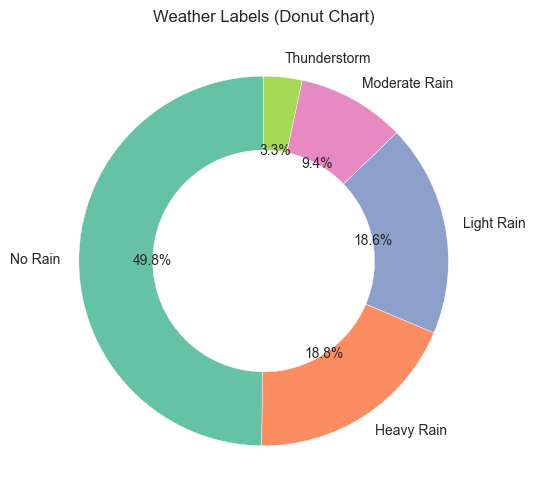

In [225]:
# Donut Chart (Circular)
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=90)
plt.setp(wedges, width=0.4)
plt.title('Weather Labels (Donut Chart)')
plt.show()

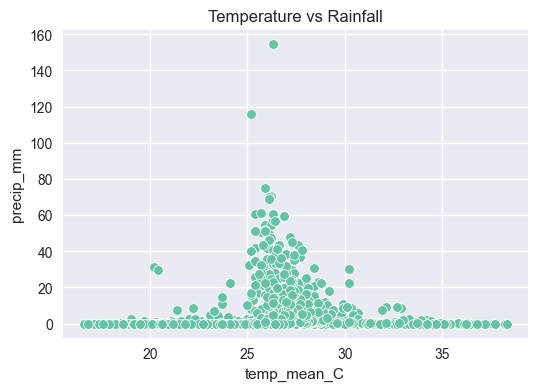

In [226]:
# Temperature vs Rainfall

# Scatter Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x='temp_mean_C', y='precip_mm', data=final_df)
plt.title('Temperature vs Rainfall')
plt.show()

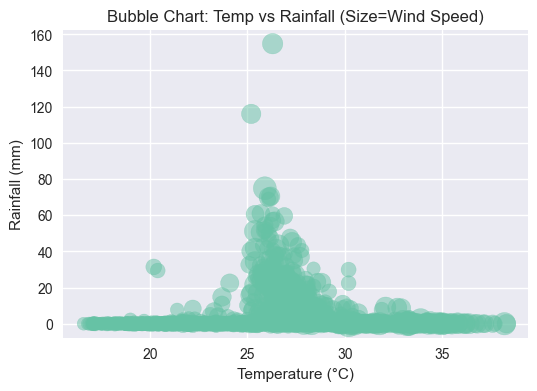

In [227]:
# Bubble Chart (Size = Wind Speed)
plt.figure(figsize=(6, 4))
plt.scatter(final_df['temp_mean_C'], final_df['precip_mm'], 
            s=final_df['wind_speed_max_m_s']*10, alpha=0.5)
plt.title('Bubble Chart: Temp vs Rainfall (Size=Wind Speed)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.show()

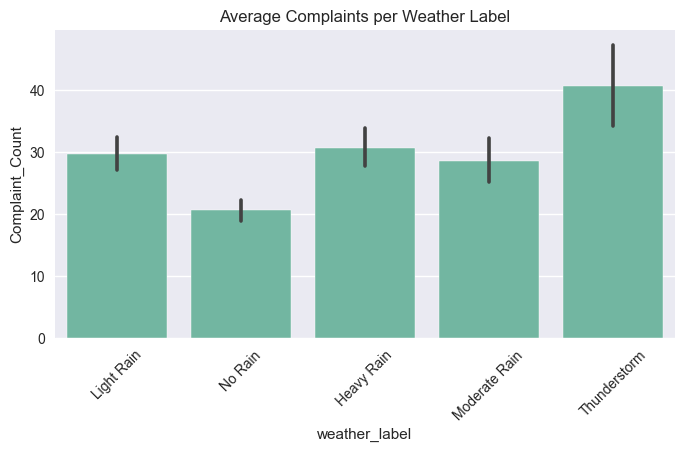

In [228]:
# Weather vs Complaints
# Column Chart
plt.figure(figsize=(8, 4))
sns.barplot(x='weather_label', y='Complaint_Count', data=final_df, estimator='mean')
plt.title('Average Complaints per Weather Label')
plt.xticks(rotation=45)
plt.show()

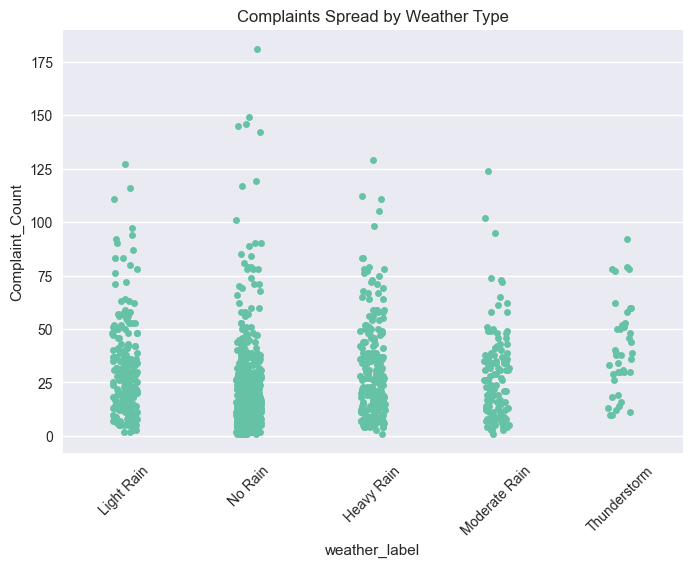

In [229]:
# Strip Plot
sns.stripplot(x='weather_label', y='Complaint_Count', data=final_df, jitter=True)
plt.title('Complaints Spread by Weather Type')
plt.xticks(rotation=45)
plt.show()

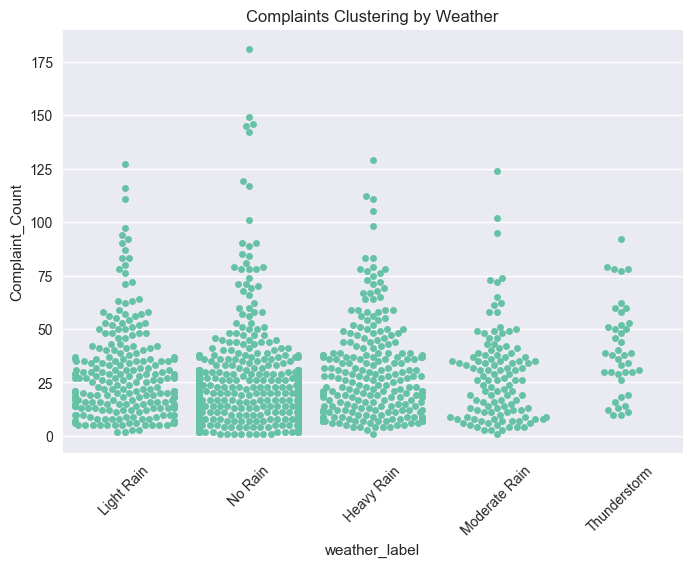

In [230]:
# Swarm Plot
sns.swarmplot(x='weather_label', y='Complaint_Count', data=final_df)
plt.title('Complaints Clustering by Weather')
plt.xticks(rotation=45)
plt.show()

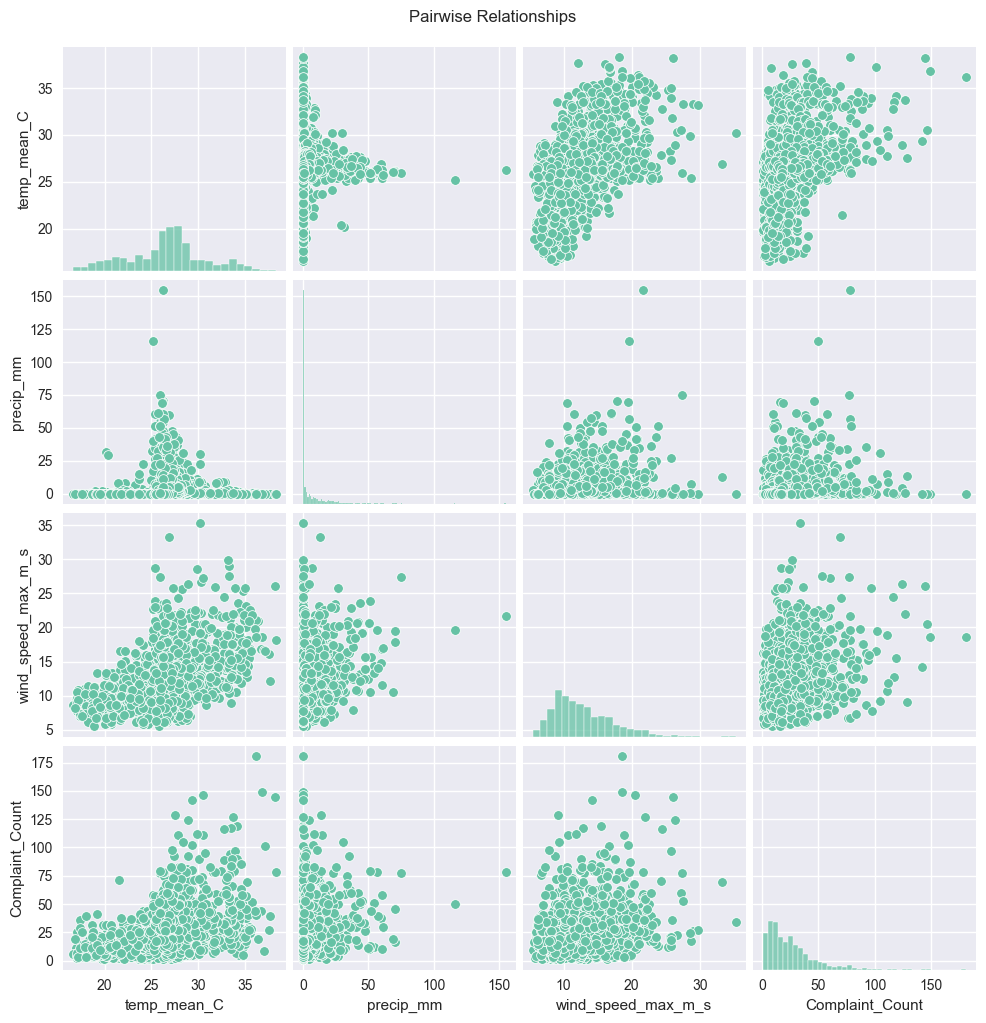

In [231]:
# MULTIVARIATE ANALYSIS (3+ variables together)
# Pair Plot for multiple relationships
sns.pairplot(final_df[['temp_mean_C', 'precip_mm', 'wind_speed_max_m_s', 'Complaint_Count']])
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

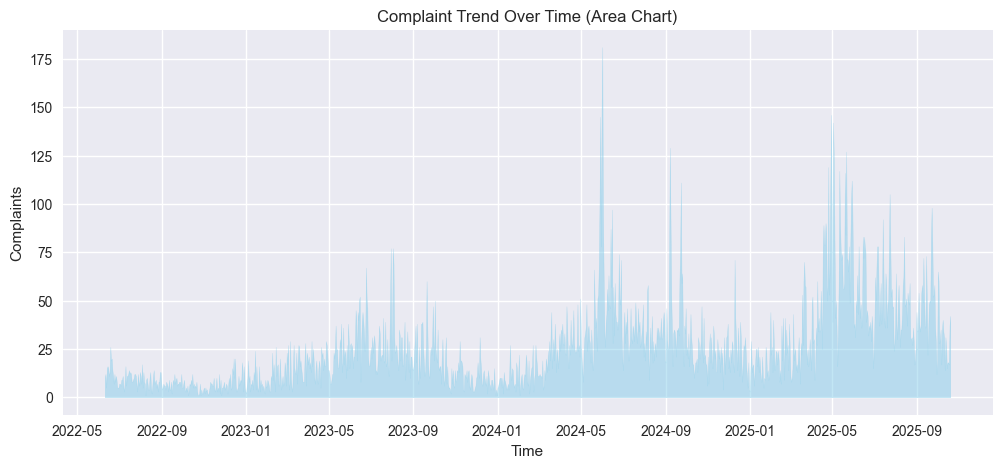

In [232]:
# Time-Series and ECDF Analysis
# Area Chart
plt.figure(figsize=(12, 5))
plt.fill_between(final_df['time'], final_df['Complaint_Count'], color='skyblue', alpha=0.5)
plt.title('Complaint Trend Over Time (Area Chart)')
plt.xlabel('Time')
plt.ylabel('Complaints')
plt.show()

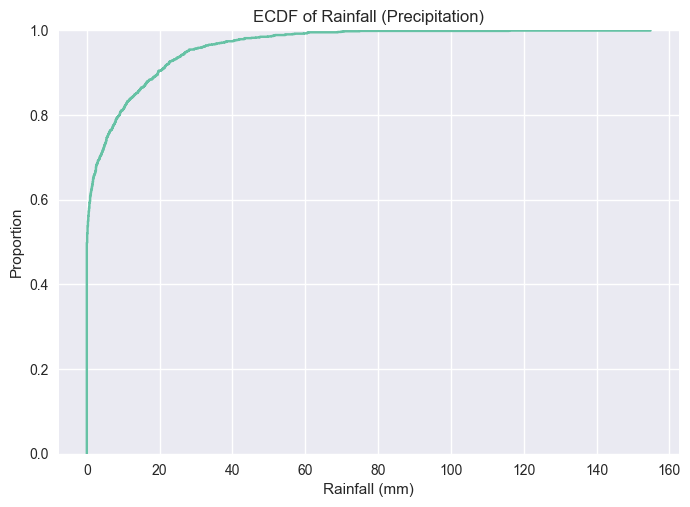

In [233]:
# ECDF Plot
sns.ecdfplot(final_df['precip_mm'])
plt.title('ECDF of Rainfall (Precipitation)')
plt.xlabel('Rainfall (mm)')
plt.show()

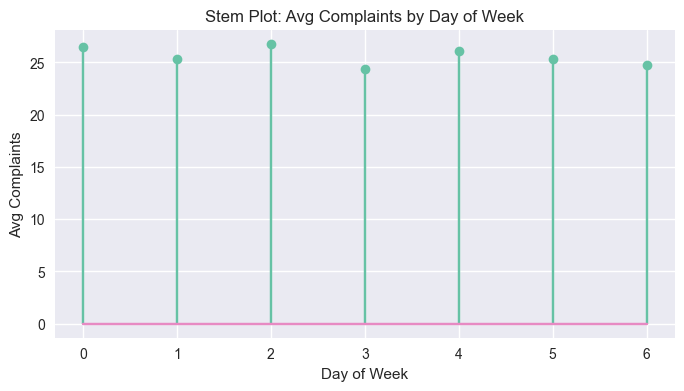

In [234]:
# Stem Plot (for day of week vs mean complaints)
plt.figure(figsize=(8, 4))
plt.stem(final_df.groupby('day_of_week')['Complaint_Count'].mean())
plt.title('Stem Plot: Avg Complaints by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Avg Complaints')
plt.show()

In [235]:
final_df.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
       'day_of_year', 'is_weekend', 'relative_humidity_2m_mean',
       'weather_label'],
      dtype='object')

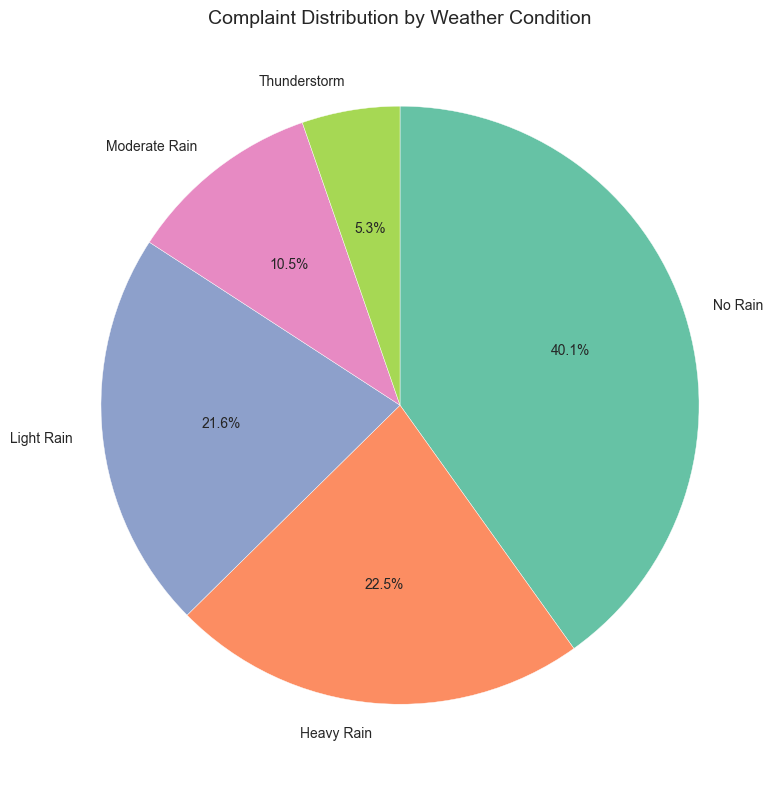

In [236]:
# Group by weather_label and sum Complaint_Count
complaints_by_weather = final_df.groupby('weather_label')['Complaint_Count'].sum().sort_values(ascending=False)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    complaints_by_weather,
    labels=complaints_by_weather.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

plt.title('Complaint Distribution by Weather Condition', fontsize=14)
plt.tight_layout()
plt.show()

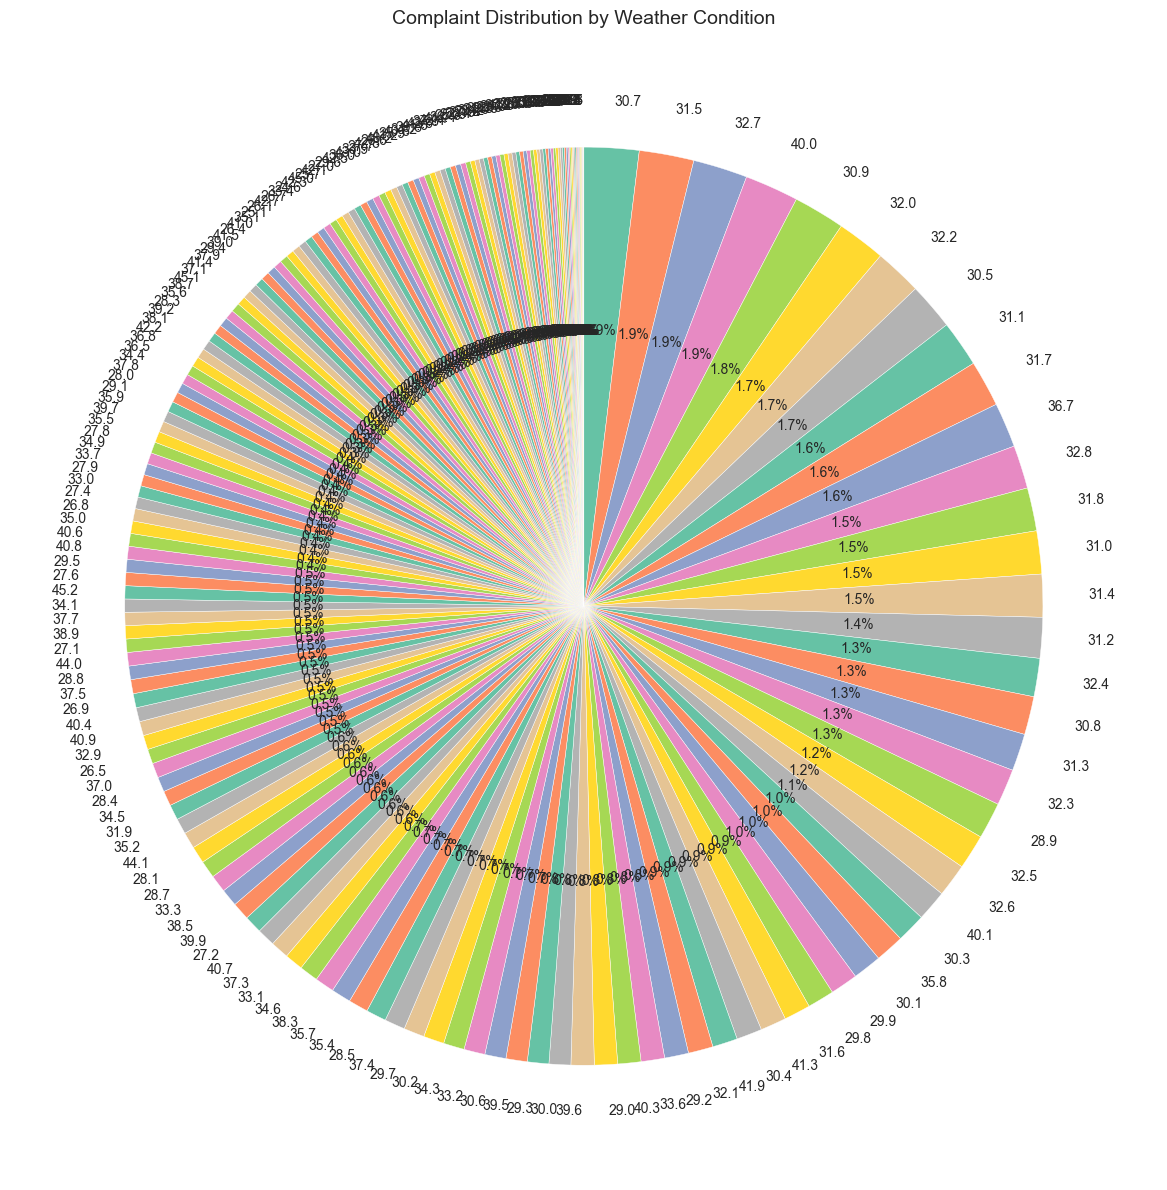

In [237]:
# Group by weather_label and sum Complaint_Count
complaints_by_weather = final_df.groupby('temp_max_C')['Complaint_Count'].sum().sort_values(ascending=False)

# Plot the pie chart
plt.figure(figsize=(12, 12))
plt.pie(
    complaints_by_weather,
    labels=complaints_by_weather.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

plt.title('Complaint Distribution by Weather Condition', fontsize=14)
plt.tight_layout()
plt.show()

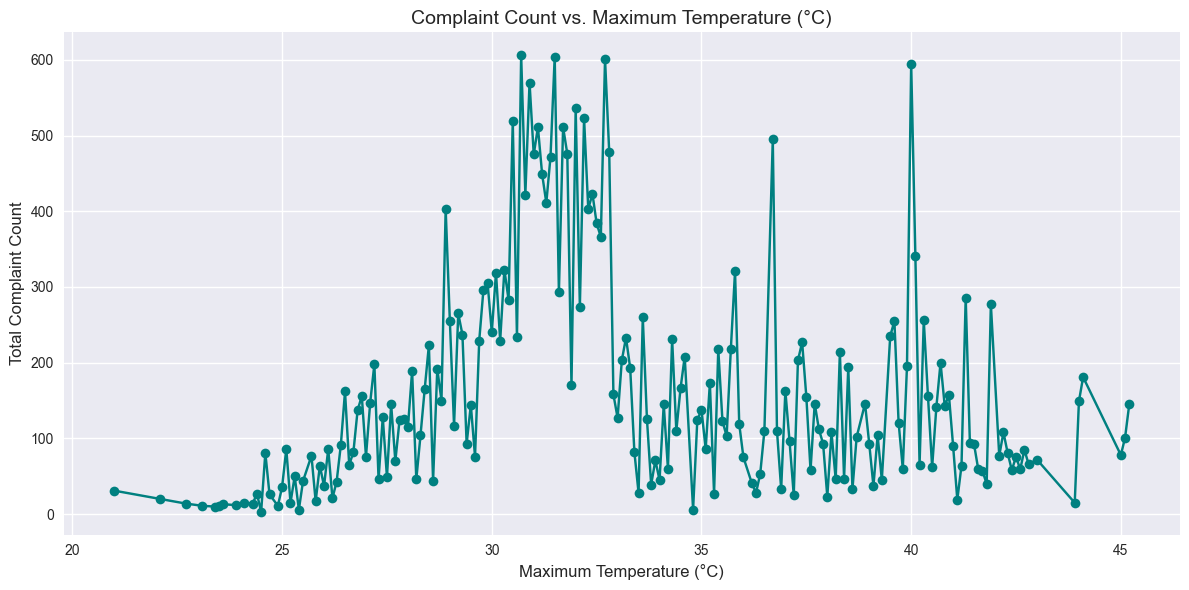

In [238]:
# Group by temp_max_C and sum Complaint_Count
complaints_by_weather = final_df.groupby('temp_max_C')['Complaint_Count'].sum().sort_index()

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(
    complaints_by_weather.index,
    complaints_by_weather.values,
    marker='o',
    linestyle='-',
    color='teal'
)

plt.title('Complaint Count vs. Maximum Temperature (°C)', fontsize=14)
plt.xlabel('Maximum Temperature (°C)', fontsize=12)
plt.ylabel('Total Complaint Count', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


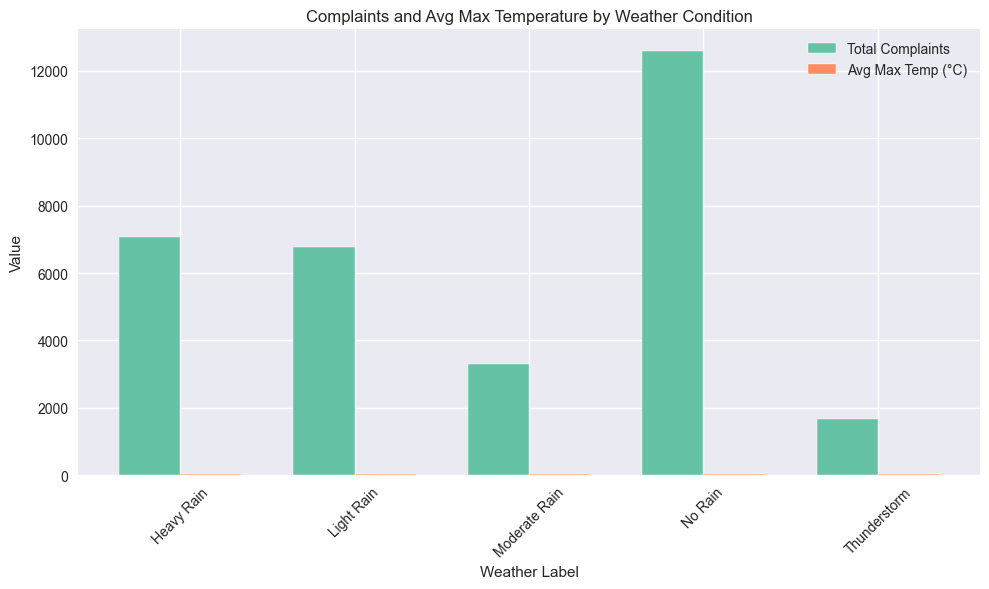

In [239]:
# Group data by weather_label
grouped = final_df.groupby('weather_label').agg({
    'Complaint_Count': 'sum',
    'temp_max_C': 'mean'
}).reset_index()

# Create side-by-side bar chart
x = np.arange(len(grouped['weather_label']))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, grouped['Complaint_Count'], width, label='Total Complaints')
plt.bar(x + width/2, grouped['temp_max_C'], width, label='Avg Max Temp (°C)')

plt.xticks(x, grouped['weather_label'], rotation=45)
plt.xlabel('Weather Label')
plt.ylabel('Value')
plt.title('Complaints and Avg Max Temperature by Weather Condition')
plt.legend()
plt.tight_layout()
plt.show()


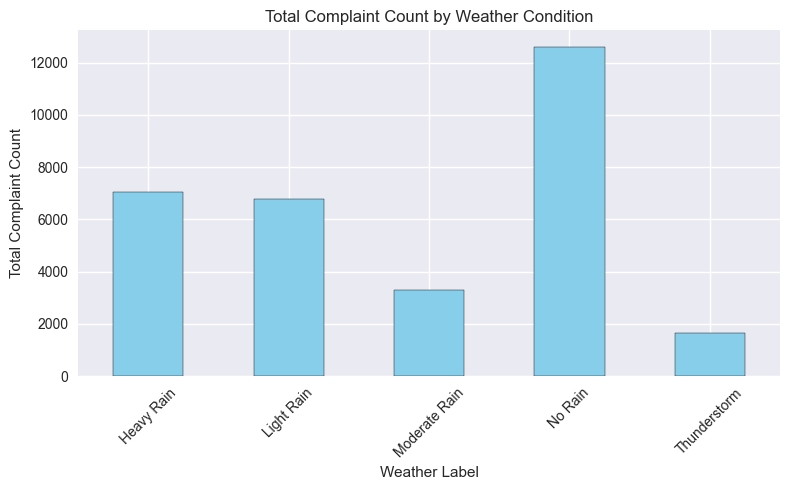

In [240]:
final_df.groupby('weather_label')['Complaint_Count'].sum().plot(
    kind='bar', figsize=(8, 5), color='skyblue', edgecolor='black'
)
plt.title('Total Complaint Count by Weather Condition')
plt.xlabel('Weather Label')
plt.ylabel('Total Complaint Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [241]:
final_df.columns

Index(['time', 'temp_max_C', 'temp_min_C', 'temp_mean_C', 'precip_mm',
       'wind_speed_max_m_s', 'weather_code', 'Complaint_Count', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'quarter', 'year',
       'day_of_year', 'is_weekend', 'relative_humidity_2m_mean',
       'weather_label'],
      dtype='object')

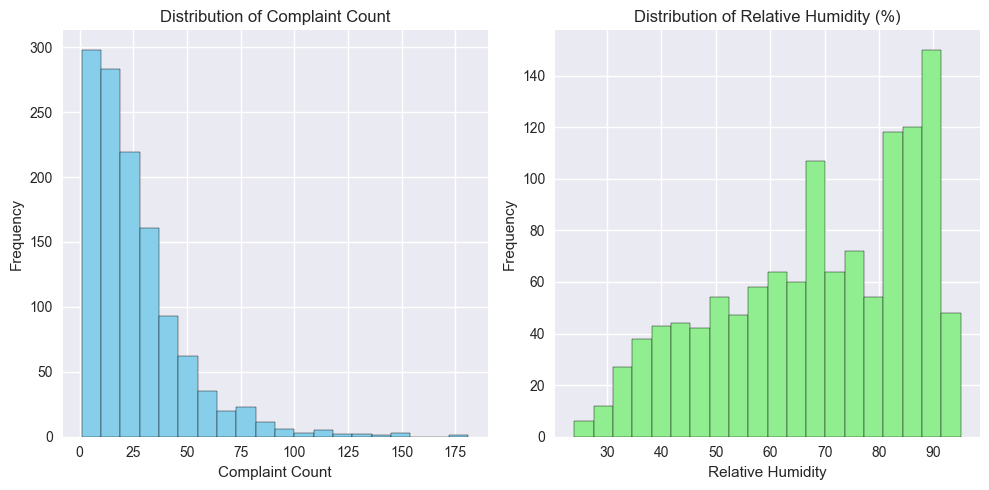

In [242]:
plt.figure(figsize=(10, 5))

# Histogram 1 - Complaint Count
plt.subplot(1, 2, 1)
plt.hist(final_df['Complaint_Count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Count')
plt.xlabel('Complaint Count')
plt.ylabel('Frequency')

# Histogram 2 - Relative Humidity
plt.subplot(1, 2, 2)
plt.hist(final_df['relative_humidity_2m_mean'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Relative Humidity (%)')
plt.xlabel('Relative Humidity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


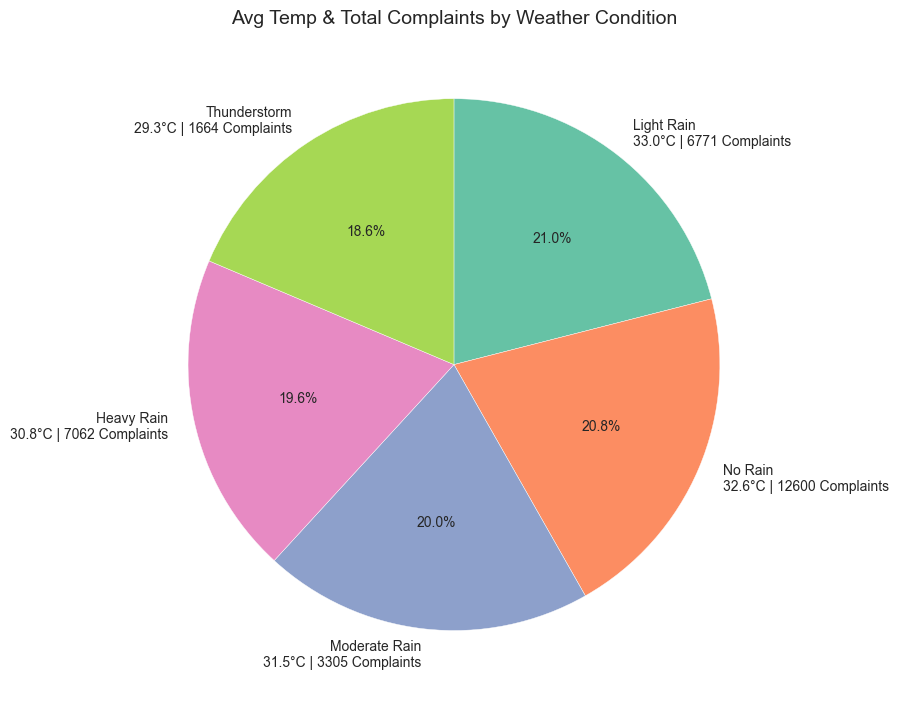

In [243]:
# Group data by weather_label
grouped = final_df.groupby('weather_label').agg({
    'temp_max_C': 'mean',
    'Complaint_Count': 'sum'
}).sort_values('temp_max_C', ascending=False)

# Create custom labels combining weather, avg temp, and complaints
labels = [
    f"{label}\n{temp:.1f}°C | {complaints} Complaints"
    for label, temp, complaints in zip(
        grouped.index, grouped['temp_max_C'], grouped['Complaint_Count']
    )
]

# Plot the pie chart (based on average temperature)
plt.figure(figsize=(9, 9))
plt.pie(
    grouped['temp_max_C'],
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

plt.title('Avg Temp & Total Complaints by Weather Condition', fontsize=14)
plt.tight_layout()
plt.show()

In [244]:
final_df.head(10)

time  temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
0 2022-06-10        41.0        30.3         34.6        0.1   
1 2022-06-11        41.0        30.8         34.8        0.2   
2 2022-06-12        39.8        29.5         34.4        0.0   
3 2022-06-13        40.2        29.5         34.7        0.0   
4 2022-06-14        39.2        30.0         32.9        8.6   
5 2022-06-15        35.6        26.1         30.7        6.0   
6 2022-06-16        36.8        26.5         30.4        0.6   
7 2022-06-17        34.3        25.5         28.6       23.2   
8 2022-06-18        31.5        25.4         27.6       11.2   
9 2022-06-19        32.7        25.2         27.3       14.8   

   wind_speed_max_m_s  weather_code  Complaint_Count  day_of_week  \
0                16.6            51               10            4   
1                25.3            51               12            5   
2                16.7             3                5            6   
3                13.3             3               15            0   
4                19.0            63               16            1   
5                17.4            63               15            2   
6                15.3            53               11            3   
7                15.2            63               13            4   
8                15.0            63               26            5   
9                20.6            63               19            6   

   day_of_month  week_of_year  month  quarter  year  day_of_year  is_weekend  \
0            10            23      6        2  2022          161           0   
1            11            23      6        2  2022          162           1   
2            12            23      6        2  2022          163           1   
3            13            24      6        2  2022          164           0   
4            14            24      6        2  2022          165           0   
5            15            24      6        2  2022          166           0   
6            16            24      6        2  2022          167           0   
7            17            24      6        2  2022          168           0   
8            18            24      6        2  2022          169           1   
9            19            24      6        2  2022          170           1   

   relative_humidity_2m_mean  weather_label  
0                         47     Light Rain  
1                         42     Light Rain  
2                         45        No Rain  
3                         45        No Rain  
4                         52     Heavy Rain  
5                         66  Moderate Rain  
6                         68     Light Rain  
7                         78     Heavy Rain  
8                         84     Heavy Rain  
9                         88     Heavy Rain

In [245]:
final_df['time'] = pd.to_datetime(df['time'])  # Ensure it's in datetime format

In [246]:
final_df.set_index('time', inplace=True)

In [247]:
final_df.head(2)

temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
time                                                         
2022-06-10        41.0        30.3         34.6        0.1   
2022-06-11        41.0        30.8         34.8        0.2   

            wind_speed_max_m_s  weather_code  Complaint_Count  day_of_week  \
time                                                                         
2022-06-10                16.6            51               10            4   
2022-06-11                25.3            51               12            5   

            day_of_month  week_of_year  month  quarter  year  day_of_year  \
time                                                                        
2022-06-10            10            23      6        2  2022          161   
2022-06-11            11            23      6        2  2022          162   

            is_weekend  relative_humidity_2m_mean weather_label  
time                                                             
2022-06-10           0                         47    Light Rain  
2022-06-11           1                         42    Light Rain

In [248]:
# Convert to category and encode
final_df['weather_label'] = pd.Categorical(final_df['weather_label']).codes

In [249]:
final_df

temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
time                                                         
2022-06-10        41.0        30.3         34.6        0.1   
2022-06-11        41.0        30.8         34.8        0.2   
2022-06-12        39.8        29.5         34.4        0.0   
2022-06-13        40.2        29.5         34.7        0.0   
2022-06-14        39.2        30.0         32.9        8.6   
...                ...         ...          ...        ...   
2025-10-15        31.4        22.4         26.4        0.0   
2025-10-16        30.9        22.2         25.9        0.0   
2025-10-17        31.0        21.7         25.5        0.0   
2025-10-18        30.5        20.6         25.5        0.0   
2025-10-19        30.2        22.6         25.9        0.6   

            wind_speed_max_m_s  weather_code  Complaint_Count  day_of_week  \
time                                                                         
2022-06-10                16.6            51               10            4   
2022-06-11                25.3            51               12            5   
2022-06-12                16.7             3                5            6   
2022-06-13                13.3             3               15            0   
2022-06-14                19.0            63               16            1   
...                        ...           ...              ...          ...   
2025-10-15                 6.1             0               18            2   
2025-10-16                 8.2             0               18            3   
2025-10-17                 7.8             0               17            4   
2025-10-18                 6.3             0               37            5   
2025-10-19                 9.4            51               42            6   

            day_of_month  week_of_year  month  quarter  year  day_of_year  \
time                                                                        
2022-06-10            10            23      6        2  2022          161   
2022-06-11            11            23      6        2  2022          162   
2022-06-12            12            23      6        2  2022          163   
2022-06-13            13            24      6        2  2022          164   
2022-06-14            14            24      6        2  2022          165   
...                  ...           ...    ...      ...   ...          ...   
2025-10-15            15            42     10        4  2025          288   
2025-10-16            16            42     10        4  2025          289   
2025-10-17            17            42     10        4  2025          290   
2025-10-18            18            42     10        4  2025          291   
2025-10-19            19            42     10        4  2025          292   

            is_weekend  relative_humidity_2m_mean  weather_label  
time                                                              
2022-06-10           0                         47              1  
2022-06-11           1                         42              1  
2022-06-12           1                         45              3  
2022-06-13           0                         45              3  
2022-06-14           0                         52              0  
...                ...                        ...            ...  
2025-10-15           0                         78              3  
2025-10-16           0                         75              3  
2025-10-17           0                         75              3  
2025-10-18           1                         77              3  
2025-10-19           1                         85              1  

[1228 rows x 17 columns]

### Feature Engineering

In [251]:
# Correlation Analysis

corr_relation_matrix = final_df.corr()

In [252]:
corr_relation_matrix

temp_max_C  temp_min_C  temp_mean_C  precip_mm  \
temp_max_C                   1.000000    0.638914     0.904602  -0.218767   
temp_min_C                   0.638914    1.000000     0.897391   0.268671   
temp_mean_C                  0.904602    0.897391     1.000000   0.018799   
precip_mm                   -0.218767    0.268671     0.018799   1.000000   
wind_speed_max_m_s           0.434599    0.491785     0.500930   0.209312   
weather_code                -0.131637    0.558141     0.218998   0.531925   
Complaint_Count              0.365313    0.462581     0.443831   0.176319   
day_of_week                 -0.006038   -0.011802    -0.007712  -0.012235   
day_of_month                -0.017220   -0.017033    -0.023405  -0.026664   
week_of_year                -0.312882    0.071797    -0.139857   0.137466   
month                       -0.314517    0.073298    -0.139484   0.138908   
quarter                     -0.331196    0.066570    -0.151270   0.139376   
year                         0.138403    0.074552     0.116909  -0.010378   
day_of_year                 -0.317644    0.068430    -0.144288   0.135225   
is_weekend                  -0.000840   -0.011925    -0.004388  -0.022250   
relative_humidity_2m_mean   -0.598375    0.151106    -0.262843   0.507040   
weather_label                0.075952   -0.442861    -0.189290  -0.206522   

                           wind_speed_max_m_s  weather_code  Complaint_Count  \
temp_max_C                           0.434599     -0.131637         0.365313   
temp_min_C                           0.491785      0.558141         0.462581   
temp_mean_C                          0.500930      0.218998         0.443831   
precip_mm                            0.209312      0.531925         0.176319   
wind_speed_max_m_s                   1.000000      0.230030         0.324915   
weather_code                         0.230030      1.000000         0.229924   
Complaint_Count                      0.324915      0.229924         1.000000   
day_of_week                          0.018715      0.013324        -0.018623   
day_of_month                        -0.012205      0.020207         0.028173   
week_of_year                        -0.204542      0.257724        -0.047699   
month                               -0.205601      0.254640        -0.057384   
quarter                             -0.216642      0.247698        -0.072649   
year                                 0.130618     -0.034610         0.539884   
day_of_year                         -0.208176      0.254033        -0.055884   
is_weekend                           0.004136      0.024064        -0.015954   
relative_humidity_2m_mean           -0.149706      0.725667         0.022287   
weather_label                       -0.154208     -0.786681        -0.147986   

                           day_of_week  day_of_month  week_of_year     month  \
temp_max_C                   -0.006038     -0.017220     -0.312882 -0.314517   
temp_min_C                   -0.011802     -0.017033      0.071797  0.073298   
temp_mean_C                  -0.007712     -0.023405     -0.139857 -0.139484   
precip_mm                    -0.012235     -0.026664      0.137466  0.138908   
wind_speed_max_m_s            0.018715     -0.012205     -0.204542 -0.205601   
weather_code                  0.013324      0.020207      0.257724  0.254640   
Complaint_Count              -0.018623      0.028173     -0.047699 -0.057384   
day_of_week                   1.000000     -0.002337     -0.000711  0.007604   
day_of_month                 -0.002337      1.000000      0.069030 -0.002528   
week_of_year                 -0.000711      0.069030      1.000000  0.981649   
month                         0.007604     -0.002528      0.981649  1.000000   
quarter                       0.004009     -0.006521      0.952420  0.968593   
year                         -0.000652     -0.030831     -0.314932 -0.322197   
day_of_year                   0.007322      0.083883      0.984154  0.996235   

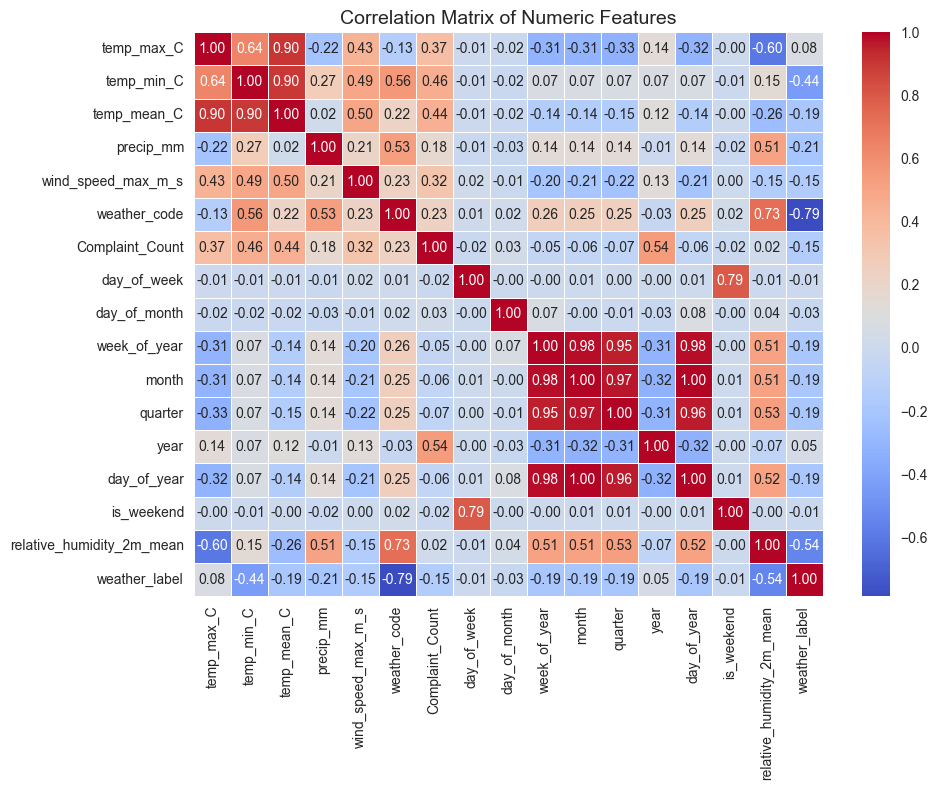

In [253]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_relation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

In [255]:
# VIF (Variance Inflation Factor

V = final_df.select_dtypes(include='number').drop(columns=['Complaint_Count'])  # drop target if needed

In [258]:
V = add_constant(V)

In [259]:
vif_data = pd.DataFrame()
vif_data['Feature'] = V.columns
vif_data['VIF'] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]

In [260]:
vif_data

Feature           VIF
0                       const  4.811250e+06
1                  temp_max_C  3.879514e+01
2                  temp_min_C  5.524957e+01
3                 temp_mean_C  1.199932e+02
4                   precip_mm  1.947966e+00
5          wind_speed_max_m_s  1.670071e+00
6                weather_code  7.250189e+00
7                 day_of_week  2.675834e+00
8                day_of_month  1.994132e+02
9                week_of_year  3.224674e+01
10                      month  2.650549e+04
11                    quarter  1.744080e+01
12                       year  1.225873e+00
13                day_of_year  2.661789e+04
14                 is_weekend  2.686025e+00
15  relative_humidity_2m_mean  9.216392e+00
16              weather_label  3.162481e+00

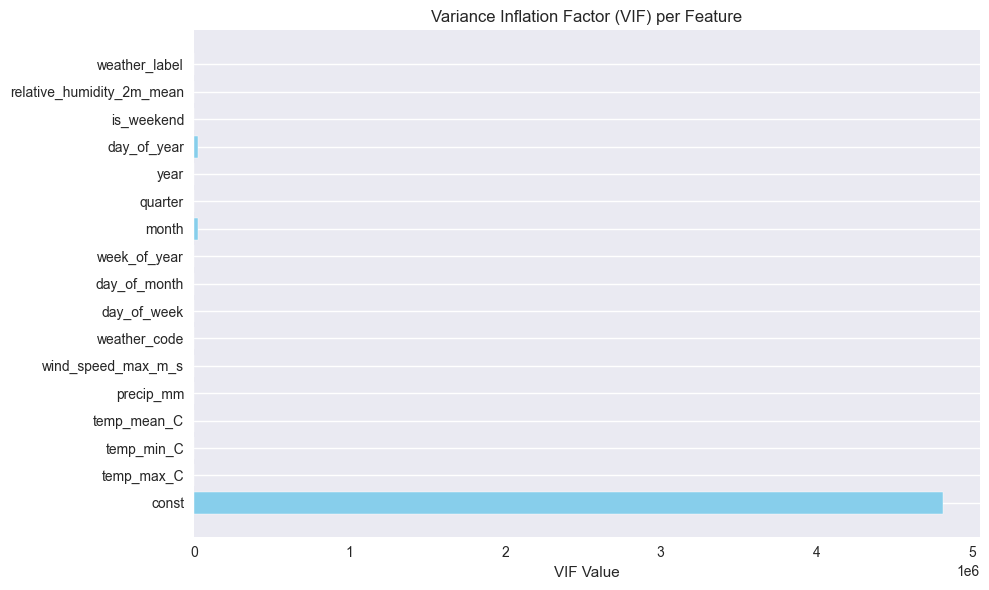

In [261]:
# Step 4: Visualize VIF values
plt.figure(figsize=(10, 6))
plt.barh(vif_data['Feature'], vif_data['VIF'], color='skyblue')
plt.xlabel('VIF Value')
plt.title('Variance Inflation Factor (VIF) per Feature')
plt.grid(axis='x')
plt.tight_layout()
plt.show()